In [ ]:
# Importing required packages for data preparation and visualization
import os
import torch
from torchvision.datasets import ImageFolder
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Subset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from collections import Counter
from torchvision.utils import make_grid
import numpy as np

In [2]:
# Installing the Kaggle API
!pip install kaggle

# Uploading the Kaggle API Key
from google.colab import files
files.upload()  # Upload the kaggle.json file here

# Moving the Kaggle API Key to the Correct Directory
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Downloading the Dataset
!kaggle datasets download -d kacpergregorowicz/house-plant-species

# Extracting the Dataset
import zipfile

zip_file = "house-plant-species.zip"  # Adjust if the filename changes
extract_dir = "/content/house-plant-species"

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Dataset extracted to: {extract_dir}")

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/kacpergregorowicz/house-plant-species
License(s): CC-BY-NC-SA-4.0
100% 4.85G/4.85G [04:27<00:00, 23.9MB/s]
100% 4.85G/4.85G [04:27<00:00, 19.5MB/s]
Dataset extracted to: /content/house-plant-species


In [3]:
# Defining the data path
data_path = "/content/house-plant-species/house_plant_species"

# Loading the Full Dataset
full_dataset = ImageFolder(data_path)

# Extracting labels
labels = [label for _, label in full_dataset.samples]

# Creating a Stratified Split
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) #80% train and 20% test
train_indices, test_indices = next(sss.split(X=range(len(labels)), y=labels))

train_dataset = Subset(full_dataset, train_indices)
test_dataset = Subset(full_dataset, test_indices)

# Getting class names
class_names = full_dataset.classes

# Printing dataset details
print(f"Total images: {len(full_dataset)}")
print(f"Training images: {len(train_dataset)}")
print(f"Testing images: {len(test_dataset)}")
print(f"Number of classes: {len(class_names)}")

Total images: 14774
Training images: 11819
Testing images: 2955
Number of classes: 47


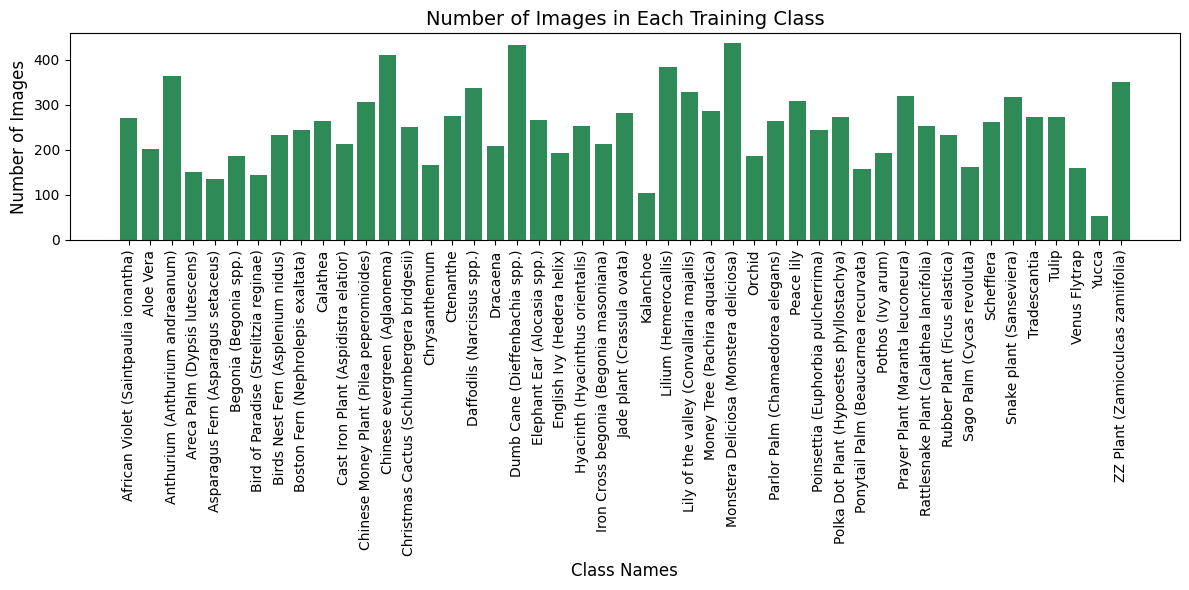

In [4]:
# Function to visualize class distributions in the training dataset
def visualize_class_distribution(train_dataset, full_dataset):
    # Getting labels from the training dataset
    train_labels = [full_dataset.targets[i] for i in train_dataset.indices]

    # Counting occurrences of each class in the training dataset
    train_counts = Counter(train_labels)

    # Sorting classes and counts for a cleaner visualization
    sorted_counts = sorted(train_counts.items(), key=lambda x: x[0])
    sorted_classes = [class_names[class_idx] for class_idx, _ in sorted_counts]
    sorted_values = [count for _, count in sorted_counts]

    # Creating a bar chart
    plt.figure(figsize=(12, 6))
    plt.bar(sorted_classes, sorted_values, color='seagreen')
    plt.xticks(rotation=90, fontsize=10)
    plt.xlabel('Class Names', fontsize=12)
    plt.ylabel('Number of Images', fontsize=12)
    plt.title('Number of Images in Each Training Class', fontsize=14)
    plt.tight_layout()
    plt.show()

# Visualizing the training dataset class distribution
visualize_class_distribution(train_dataset, full_dataset)


In [5]:
# Defining train transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resizing to 224x224
    transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
    transforms.ColorJitter(brightness=0.1, contrast=0.2, saturation=0.2, hue=0.1),  # Random color jitter
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),  # Random affine transformations
    transforms.ToTensor(),  # Converting to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Defining test transformations
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resizing to 224x224
    transforms.ToTensor(),  # Converting to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Applying transformations to datasets
train_dataset = Subset(
    ImageFolder(data_path, transform=train_transform), train_indices
)
test_dataset = Subset(
    ImageFolder(data_path, transform=test_transform), test_indices
)

In [6]:
# Creating DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train Loader: {len(train_loader)} batches, Batch size: {batch_size}")
print(f"Test Loader: {len(test_loader)} batches, Batch size: {batch_size}")

Train Loader: 185 batches, Batch size: 64
Test Loader: 47 batches, Batch size: 64


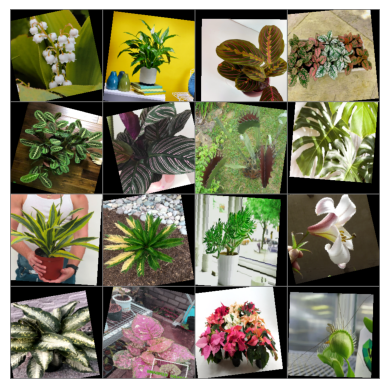

In [7]:
# Defining function to visualize plant images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalizing the image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

def show_batch_images(dataloader, num_images=16):
    data_iter = iter(dataloader)
    images, labels = next(data_iter)
    images = images[:num_images]
    img_grid = make_grid(images, nrow=4)
    imshow(img_grid)

# Visualizing a batch of images from the training DataLoader
show_batch_images(train_loader, num_images=16)

#Model Architechture

##ViT pre-trained on ImageNet

In [9]:
import timm
import torch.nn as nn
use_gpu = True
device = "cuda" if torch.cuda.is_available() and use_gpu else "cpu"

# Loading pre-trained ViT
model_vit = timm.create_model('vit_base_patch16_224', pretrained=True)

# Freezing the pre-trained layers
for param in model_vit.parameters():
    param.requires_grad = False

# Modifying the classification head for your 47 classes
num_classes = 47
num_features = model_vit.head.in_features
model_vit.head = nn.Linear(num_features, num_classes)

# Ensuring the classification head remains trainable
for param in model_vit.head.parameters():
    param.requires_grad = True

# Moving the model to the correct device
model_vit.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

## ViT Pre-trained on PlantNet

In [ ]:
from timm import create_model

# Loading ViT pre-trained on PlantNet
filename = 'vit_base_patch16_224_weights_best_acc.tar'

# Initializing the ViT model
model_vit2 = create_model('vit_base_patch16_224', pretrained=False, num_classes=1081)  # 1081 classes as per PlantNet

# Loading the pre-trained weights
def load_vit_model(model, filename, device):
    if not filename:
        raise FileNotFoundError(f"File {filename} not found!")

    # Loading weights
    weights = torch.load(filename, map_location=device)
    model.load_state_dict(weights['model'])
    return weights['epoch']

# Loading PlantNet weights
load_vit_model(model_vit2, filename, device)

# Freezing the pre-trained layers
for param in model_vit2.parameters():
    param.requires_grad = False

# Modifying the classifier for 47 classes
num_features = model_vit2.head.in_features
model_vit2.head = nn.Linear(num_features, 47)

# Moving the model to the correct device
model_vit2.to(device)

print("Pre-trained ViT model loaded and customized for 47 classes.")

<ipython-input-24-001d995d6cba>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(filename, map_location=device)


Pre-trained ViT model loaded and customized for 47 classes.


## Custom ViT to be trained on our dataset

In [ ]:
# Defining Vision Transformer (ViT) Model
model_vit3 = timm.create_model('vit_base_patch16_224', pretrained=False)  # No pre-training

# Replacing the classification head
num_features = model_vit3.head.in_features  # Get the number of features in the existing classification head
model_vit3.head = nn.Linear(num_features, 47)  # Modify the head to output 47 classes

# Moving the model to the correct device
model_vit3.to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

##Custom EfficientNet-B3

In [10]:
# Defining EfficientNet-B3
model_effnet_b3 = timm.create_model('efficientnet_b3', pretrained=False)  # No pre-training

# Replacing the classification head
num_features = model_effnet_b3.get_classifier().in_features
model_effnet_b3.classifier = nn.Linear(num_features, 47)

# Moving the model to the correct device
model_effnet_b3.to(device)

EfficientNet(
  (conv_stem): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
        (bn1): BatchNormAct2d(
          40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (b

##Training

In [11]:
# Importing packages for training and evaluation
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns

In [12]:
# Creating the training and testing loop
def train_test_loop(
    model,
    train_loader,
    test_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    num_epochs=10,
    patience=5,
    save_path="best_model.pth"
):
    # Moving the model to the correct device
    model.to(device)

    # Mixed precision training (if needed)
    scaler = GradScaler()

    # Early stopping parameters
    best_test_loss = float('inf')
    best_model = None
    epochs_without_improvement = 0

    # Track metrics
    train_losses = []
    test_losses = []
    f1_scores = []
    confusion_matrices = []

    for epoch in range(num_epochs):
        ### Training Phase ###
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Train]")
        for inputs, labels in train_pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass with mixed precision
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            # Backward pass and optimizer step
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # Track loss and accuracy
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            correct_train += predicted.eq(labels).sum().item()
            total_train += labels.size(0)
            train_pbar.set_postfix({'loss': train_loss / (train_pbar.n + 1), 'accuracy': correct_train / total_train})

        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_losses.append(avg_train_loss)

        # Scheduler step
        scheduler.step()

        ### Validation Phase ###
        model.eval()
        test_loss = 0.0
        correct_test = 0
        total_test = 0
        all_labels = []
        all_predictions = []

        with torch.no_grad():
            test_pbar = tqdm(test_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Test]")
            for inputs, labels in test_pbar:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Track loss and accuracy
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                correct_test += predicted.eq(labels).sum().item()
                total_test += labels.size(0)

                # Collecting labels and predictions for F1 and confusion matrix
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

                test_pbar.set_postfix({'loss': test_loss / (test_pbar.n + 1), 'accuracy': correct_test / total_test})

        avg_test_loss = test_loss / len(test_loader)
        test_accuracy = correct_test / total_test
        test_losses.append(avg_test_loss)

        # Calculating F1 Score and Confusion Matrix
        epoch_f1_score = f1_score(all_labels, all_predictions, average="weighted")
        epoch_conf_matrix = confusion_matrix(all_labels, all_predictions)
        f1_scores.append(epoch_f1_score)
        confusion_matrices.append(epoch_conf_matrix)

        # Printing epoch results
        print(f"Epoch {epoch + 1}/{num_epochs}:")
        print(f"  Train Loss: {avg_train_loss:.4f} | Train Accuracy: {train_accuracy:.4f}")
        print(f"  Test Loss: {avg_test_loss:.4f} | Test Accuracy: {test_accuracy:.4f}")
        print(f"  F1 Score: {epoch_f1_score:.4f}")
        print(f"  Learning Rate: {scheduler.get_last_lr()[0]:.6f}")

        ### Early Stopping ###
        if avg_test_loss < best_test_loss:
            best_test_loss = avg_test_loss
            best_model = model.state_dict().copy()
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break

    # Saving the best model
    if best_model is not None:
        torch.save(best_model, save_path)
        print(f"Best model saved to {save_path}")

    return train_losses, test_losses, f1_scores, confusion_matrices

In [13]:
# Accounting for data imbalance
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(full_dataset.targets),
    y=full_dataset.targets
)

# Converting to a tensor and pass to CrossEntropyLoss
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [ ]:
# Defining function for loss visualization
def plot_loss(train_losses, test_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label="Train Loss", marker='o')
    plt.plot(test_losses, label="Test Loss", marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Train and Test Loss Across Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# Defining function for F1 scores
def plot_f1_scores(f1_scores):
    plt.figure(figsize=(10, 6))
    plt.plot(f1_scores, label="F1 Score", color='green', marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("F1 Score")
    plt.title("F1 Score Across Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# Function for enhanced confusion matrix visualization
def plot_confusion_matrix(confusion_matrix, class_names):
    normalized_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(20, 16))  # Increase the figure size for better clarity
    sns.heatmap(
        normalized_matrix,
        annot=False,  # Remove annotations in the heatmap cells for readability
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
        cbar_kws={'label': 'Normalized Frequency'},
        linewidths=0.3,  # Add gridlines with finer lines
        linecolor='gray'
    )
    plt.xlabel("Predicted Labels", fontsize=14, labelpad=10)  # Add padding for better spacing
    plt.ylabel("True Labels", fontsize=14, labelpad=10)
    plt.title("Normalized Confusion Matrix", fontsize=18)
    plt.xticks(rotation=90, ha='center', fontsize=10)  # Rotate x-axis labels with central alignment
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()

### ViT pre-trained on ImageNet

In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingLR

# Defining model and optimizer
model=model_vit
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

# Defining scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=10)

In [ ]:
#Initialzing training
train_losses, test_losses, f1_scores, conf_matrices = train_test_loop(
    model=model_vit,
    train_loader=train_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=20,
    patience=3,
    save_path="ViT_best.pth"
)

print("Training complete!")

<ipython-input-51-ebfd03dc1cf0>:18: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/20 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-51-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/20 [Train]:   2%|▏         | 3/185 [00:06<06:50,  2.25s/it, loss=4, accuracy=0.0625]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 1/20 [Test]: 100%|██████████| 47/47 [01:49<00:00,  2.32s/it, loss=0.439, accuracy=0.892]


Epoch 1/20:
  Train Loss: 1.0438 | Train Accuracy: 0.7725
  Test Loss: 0.4393 | Test Accuracy: 0.8917
  F1 Score: 0.8940
  Learning Rate: 0.000976


Epoch 2/20 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-51-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 2/20 [Train]:   7%|▋         | 13/185 [00:31<07:19,  2.55s/it, loss=0.447, accuracy=0.893]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 2/20 [Test]: 100%|██████████| 47/47 [01:49<00:00,  2.32s/it, loss=0.313, accuracy=0.918]


Epoch 2/20:
  Train Loss: 0.3860 | Train Accuracy: 0.9041
  Test Loss: 0.3134 | Test Accuracy: 0.9184
  F1 Score: 0.9192
  Learning Rate: 0.000905


Epoch 3/20 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-51-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 3/20 [Train]:   1%|          | 1/185 [00:02<07:00,  2.29s/it, loss=0.336, accuracy=0.938]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 3/20 [Test]: 100%|██████████| 47/47 [01:49<00:00,  2.32s/it, loss=0.279, accuracy=0.919]


Epoch 3/20:
  Train Loss: 0.2874 | Train Accuracy: 0.9263
  Test Loss: 0.2785 | Test Accuracy: 0.9191
  F1 Score: 0.9193
  Learning Rate: 0.000794


Epoch 4/20 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-51-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 4/20 [Train]:   2%|▏         | 4/185 [00:09<06:48,  2.26s/it, loss=0.207, accuracy=0.945]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 4/20 [Test]: 100%|██████████| 47/47 [01:52<00:00,  2.39s/it, loss=0.264, accuracy=0.921]


Epoch 4/20:
  Train Loss: 0.2372 | Train Accuracy: 0.9400
  Test Loss: 0.2639 | Test Accuracy: 0.9215
  F1 Score: 0.9230
  Learning Rate: 0.000655


Epoch 5/20 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-51-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 5/20 [Train]:   3%|▎         | 6/185 [00:16<08:11,  2.74s/it, loss=0.279, accuracy=0.927]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 5/20 [Test]: 100%|██████████| 47/47 [01:49<00:00,  2.33s/it, loss=0.247, accuracy=0.929]


Epoch 5/20:
  Train Loss: 0.2016 | Train Accuracy: 0.9489
  Test Loss: 0.2468 | Test Accuracy: 0.9289
  F1 Score: 0.9291
  Learning Rate: 0.000500


Epoch 6/20 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-51-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 6/20 [Train]:   2%|▏         | 3/185 [00:08<08:34,  2.83s/it, loss=0.233, accuracy=0.948]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 6/20 [Test]: 100%|██████████| 47/47 [01:48<00:00,  2.32s/it, loss=0.242, accuracy=0.933]


Epoch 6/20:
  Train Loss: 0.1856 | Train Accuracy: 0.9514
  Test Loss: 0.2419 | Test Accuracy: 0.9333
  F1 Score: 0.9336
  Learning Rate: 0.000345


Epoch 7/20 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-51-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 7/20 [Train]:   2%|▏         | 3/185 [00:07<07:29,  2.47s/it, loss=0.19, accuracy=0.964]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 7/20 [Test]: 100%|██████████| 47/47 [01:49<00:00,  2.32s/it, loss=0.239, accuracy=0.93]


Epoch 7/20:
  Train Loss: 0.1652 | Train Accuracy: 0.9571
  Test Loss: 0.2387 | Test Accuracy: 0.9299
  F1 Score: 0.9295
  Learning Rate: 0.000206


Epoch 8/20 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-51-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 8/20 [Train]:   1%|          | 1/185 [00:02<07:27,  2.43s/it, loss=0.114, accuracy=0.969]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 8/20 [Test]: 100%|██████████| 47/47 [01:48<00:00,  2.32s/it, loss=0.232, accuracy=0.937]


Epoch 8/20:
  Train Loss: 0.1588 | Train Accuracy: 0.9604
  Test Loss: 0.2325 | Test Accuracy: 0.9367
  F1 Score: 0.9368
  Learning Rate: 0.000095


Epoch 9/20 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
<ipython-input-51-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 9/20 [Test]: 100%|██████████| 47/47 [01:49<00:00,  2.32s/it, loss=0.233, accuracy=0.936]


Epoch 9/20:
  Train Loss: 0.1517 | Train Accuracy: 0.9620
  Test Loss: 0.2326 | Test Accuracy: 0.9360
  F1 Score: 0.9361
  Learning Rate: 0.000024


Epoch 10/20 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
<ipython-input-51-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 10/20 [Test]: 100%|██████████| 47/47 [01:49<00:00,  2.32s/it, loss=0.231, accuracy=0.937]


Epoch 10/20:
  Train Loss: 0.1464 | Train Accuracy: 0.9639
  Test Loss: 0.2310 | Test Accuracy: 0.9371
  F1 Score: 0.9373
  Learning Rate: 0.000000


Epoch 11/20 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-51-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 11/20 [Train]:   4%|▍         | 7/185 [00:16<06:56,  2.34s/it, loss=0.132, accuracy=0.969]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 11/20 [Test]: 100%|██████████| 47/47 [01:49<00:00,  2.32s/it, loss=0.231, accuracy=0.937]


Epoch 11/20:
  Train Loss: 0.1442 | Train Accuracy: 0.9628
  Test Loss: 0.2310 | Test Accuracy: 0.9371
  F1 Score: 0.9373
  Learning Rate: 0.000024


Epoch 12/20 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-51-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 12/20 [Train]:   3%|▎         | 6/185 [00:17<08:48,  2.95s/it, loss=0.117, accuracy=0.969]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 12/20 [Test]: 100%|██████████| 47/47 [01:48<00:00,  2.31s/it, loss=0.231, accuracy=0.936]


Epoch 12/20:
  Train Loss: 0.1454 | Train Accuracy: 0.9635
  Test Loss: 0.2309 | Test Accuracy: 0.9360
  F1 Score: 0.9362
  Learning Rate: 0.000095


Epoch 13/20 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-51-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 13/20 [Train]:   2%|▏         | 3/185 [00:07<07:36,  2.51s/it, loss=0.101, accuracy=0.984]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 13/20 [Test]: 100%|██████████| 47/47 [01:50<00:00,  2.34s/it, loss=0.231, accuracy=0.934]


Epoch 13/20:
  Train Loss: 0.1434 | Train Accuracy: 0.9646
  Test Loss: 0.2311 | Test Accuracy: 0.9340
  F1 Score: 0.9343
  Learning Rate: 0.000206


Epoch 14/20 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-51-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 14/20 [Train]:   4%|▍         | 7/185 [00:18<07:43,  2.61s/it, loss=0.105, accuracy=0.978]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 14/20 [Test]: 100%|██████████| 47/47 [01:50<00:00,  2.34s/it, loss=0.231, accuracy=0.937]


Epoch 14/20:
  Train Loss: 0.1492 | Train Accuracy: 0.9618
  Test Loss: 0.2306 | Test Accuracy: 0.9374
  F1 Score: 0.9375
  Learning Rate: 0.000345


Epoch 15/20 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-51-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 15/20 [Train]:   2%|▏         | 4/185 [00:10<08:15,  2.74s/it, loss=0.127, accuracy=0.965]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 15/20 [Test]: 100%|██████████| 47/47 [01:49<00:00,  2.34s/it, loss=0.23, accuracy=0.934]


Epoch 15/20:
  Train Loss: 0.1444 | Train Accuracy: 0.9618
  Test Loss: 0.2295 | Test Accuracy: 0.9337
  F1 Score: 0.9334
  Learning Rate: 0.000500


Epoch 16/20 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
<ipython-input-51-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 16/20 [Test]: 100%|██████████| 47/47 [01:50<00:00,  2.34s/it, loss=0.23, accuracy=0.938]


Epoch 16/20:
  Train Loss: 0.1437 | Train Accuracy: 0.9614
  Test Loss: 0.2298 | Test Accuracy: 0.9381
  F1 Score: 0.9380
  Learning Rate: 0.000655


Epoch 17/20 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-51-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 17/20 [Train]:   1%|          | 2/185 [00:05<08:23,  2.75s/it, loss=0.101, accuracy=0.984]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 17/20 [Test]: 100%|██████████| 47/47 [01:48<00:00,  2.31s/it, loss=0.244, accuracy=0.926]


Epoch 17/20:
  Train Loss: 0.1409 | Train Accuracy: 0.9617
  Test Loss: 0.2443 | Test Accuracy: 0.9255
  F1 Score: 0.9261
  Learning Rate: 0.000794


Epoch 18/20 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-51-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 18/20 [Train]:   8%|▊         | 14/185 [00:38<07:56,  2.79s/it, loss=0.137, accuracy=0.951]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 18/20 [Test]: 100%|██████████| 47/47 [01:48<00:00,  2.31s/it, loss=0.225, accuracy=0.935]


Epoch 18/20:
  Train Loss: 0.1396 | Train Accuracy: 0.9587
  Test Loss: 0.2247 | Test Accuracy: 0.9350
  F1 Score: 0.9344
  Learning Rate: 0.000905


Epoch 19/20 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-51-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 19/20 [Train]:   5%|▍         | 9/185 [00:23<07:37,  2.60s/it, loss=0.11, accuracy=0.965]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 19/20 [Test]: 100%|██████████| 47/47 [01:48<00:00,  2.31s/it, loss=0.229, accuracy=0.932]


Epoch 19/20:
  Train Loss: 0.1289 | Train Accuracy: 0.9609
  Test Loss: 0.2293 | Test Accuracy: 0.9320
  F1 Score: 0.9320
  Learning Rate: 0.000976


Epoch 20/20 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-51-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 20/20 [Train]:  17%|█▋        | 31/185 [01:18<06:37,  2.58s/it, loss=0.137, accuracy=0.957]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 20/20 [Test]: 100%|██████████| 47/47 [01:48<00:00,  2.31s/it, loss=0.246, accuracy=0.925]


Epoch 20/20:
  Train Loss: 0.1282 | Train Accuracy: 0.9631
  Test Loss: 0.2458 | Test Accuracy: 0.9252
  F1 Score: 0.9243
  Learning Rate: 0.001000
Best model saved to ViT_best.pth
Training complete!


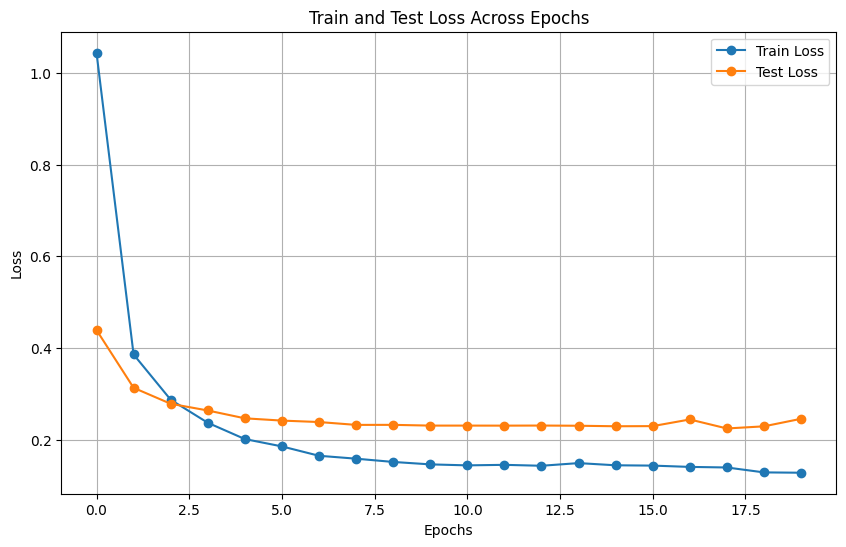

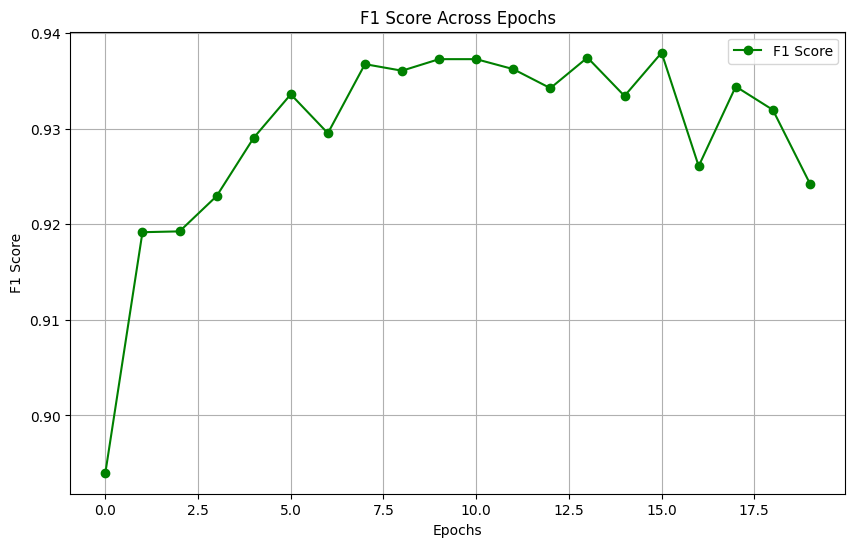

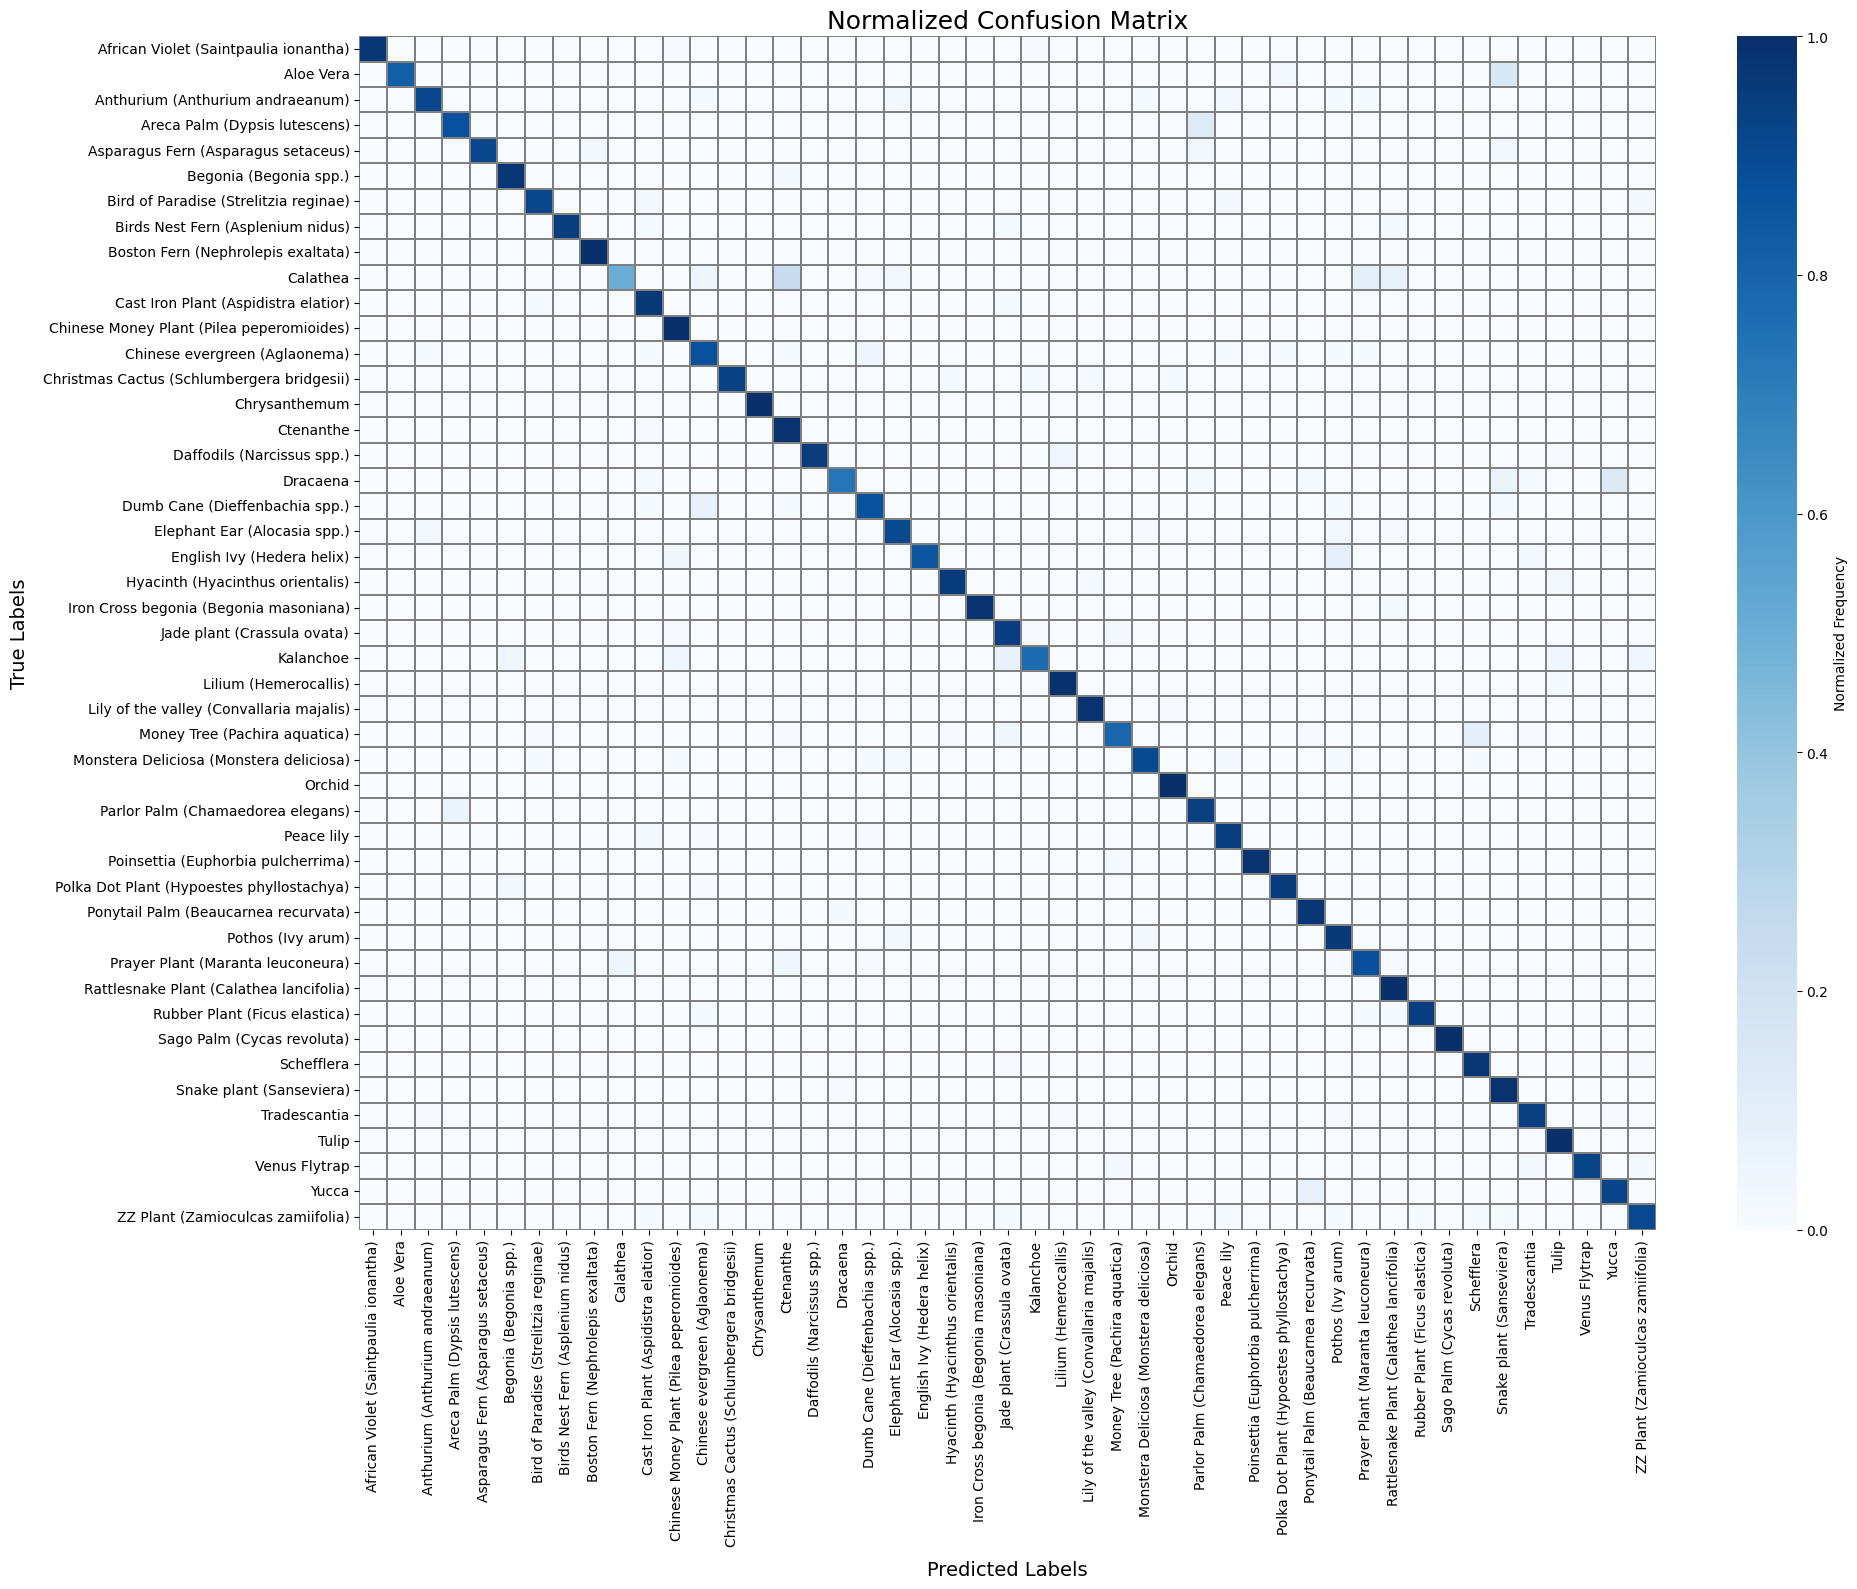

In [ ]:
# Visualizing train/test loss
plot_loss(train_losses, test_losses)

# Visualizing F1 scores
plot_f1_scores(f1_scores)

# Visualizing the confusion matrix for the last epoch
plot_confusion_matrix(conf_matrices[-1], class_names)


### ViT pre-trained on PlantNet

In [ ]:
from torch.optim.lr_scheduler import OneCycleLR

# Defining model and optimizer
model=model_vit2
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

# Defining scheduler
scheduler = OneCycleLR(optimizer, max_lr=0.001, steps_per_epoch=len(train_loader), epochs=20)

In [ ]:
# Initializing training
train_losses, test_losses, f1_scores, conf_matrices = train_test_loop(
    model=model_vit2,
    train_loader=train_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=20,
    patience=3,
    save_path="ViT2_best.pth"
)

print("Training complete!")

<ipython-input-12-ebfd03dc1cf0>:18: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/20 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/20 [Train]:   5%|▍         | 9/185 [00:23<07:09,  2.44s/it, loss=3.99, accuracy=0.026]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 1/20 [Test]: 100%|██████████| 47/47 [01:54<00:00,  2.44s/it, loss=2.51, accuracy=0.6]


Epoch 1/20:
  Train Loss: 3.3072 | Train Accuracy: 0.2443
  Test Loss: 2.5119 | Test Accuracy: 0.5997
  F1 Score: 0.5850
  Learning Rate: 0.000040


Epoch 2/20 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 2/20 [Test]: 100%|██████████| 47/47 [01:54<00:00,  2.44s/it, loss=1.51, accuracy=0.81]


Epoch 2/20:
  Train Loss: 2.0874 | Train Accuracy: 0.6797
  Test Loss: 1.5145 | Test Accuracy: 0.8102
  F1 Score: 0.8043
  Learning Rate: 0.000040


Epoch 3/20 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 3/20 [Test]: 100%|██████████| 47/47 [01:54<00:00,  2.44s/it, loss=1.02, accuracy=0.851]


Epoch 3/20:
  Train Loss: 1.3911 | Train Accuracy: 0.7911
  Test Loss: 1.0212 | Test Accuracy: 0.8511
  F1 Score: 0.8463
  Learning Rate: 0.000040


Epoch 4/20 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 4/20 [Train]:   5%|▌         | 10/185 [00:26<07:22,  2.53s/it, loss=1.17, accuracy=0.803]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 4/20 [Test]: 100%|██████████| 47/47 [01:54<00:00,  2.44s/it, loss=0.778, accuracy=0.869]


Epoch 4/20:
  Train Loss: 1.0443 | Train Accuracy: 0.8250
  Test Loss: 0.7784 | Test Accuracy: 0.8690
  F1 Score: 0.8653
  Learning Rate: 0.000040


Epoch 5/20 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 5/20 [Train]:   2%|▏         | 4/185 [00:10<08:10,  2.71s/it, loss=0.923, accuracy=0.859]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 5/20 [Test]: 100%|██████████| 47/47 [01:54<00:00,  2.44s/it, loss=0.642, accuracy=0.88]


Epoch 5/20:
  Train Loss: 0.8471 | Train Accuracy: 0.8427
  Test Loss: 0.6421 | Test Accuracy: 0.8799
  F1 Score: 0.8771
  Learning Rate: 0.000040


Epoch 6/20 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 6/20 [Train]:   2%|▏         | 4/185 [00:11<08:22,  2.77s/it, loss=0.754, accuracy=0.855]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 6/20 [Test]: 100%|██████████| 47/47 [01:54<00:00,  2.43s/it, loss=0.558, accuracy=0.886]


Epoch 6/20:
  Train Loss: 0.7332 | Train Accuracy: 0.8513
  Test Loss: 0.5578 | Test Accuracy: 0.8856
  F1 Score: 0.8835
  Learning Rate: 0.000040


Epoch 7/20 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 7/20 [Train]:   9%|▊         | 16/185 [00:44<07:29,  2.66s/it, loss=0.665, accuracy=0.87]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 7/20 [Test]: 100%|██████████| 47/47 [01:53<00:00,  2.43s/it, loss=0.5, accuracy=0.893]


Epoch 7/20:
  Train Loss: 0.6481 | Train Accuracy: 0.8597
  Test Loss: 0.5002 | Test Accuracy: 0.8927
  F1 Score: 0.8913
  Learning Rate: 0.000040


Epoch 8/20 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 8/20 [Train]:   5%|▌         | 10/185 [00:26<07:53,  2.70s/it, loss=0.619, accuracy=0.858]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 8/20 [Test]: 100%|██████████| 47/47 [01:53<00:00,  2.42s/it, loss=0.457, accuracy=0.897]


Epoch 8/20:
  Train Loss: 0.5922 | Train Accuracy: 0.8689
  Test Loss: 0.4574 | Test Accuracy: 0.8975
  F1 Score: 0.8960
  Learning Rate: 0.000040


Epoch 9/20 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 9/20 [Train]:   1%|          | 2/185 [00:05<07:55,  2.60s/it, loss=0.47, accuracy=0.898]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 9/20 [Test]: 100%|██████████| 47/47 [01:54<00:00,  2.43s/it, loss=0.426, accuracy=0.902]


Epoch 9/20:
  Train Loss: 0.5400 | Train Accuracy: 0.8788
  Test Loss: 0.4263 | Test Accuracy: 0.9015
  F1 Score: 0.9002
  Learning Rate: 0.000040


Epoch 10/20 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 10/20 [Train]:   1%|          | 2/185 [00:05<08:40,  2.85s/it, loss=0.444, accuracy=0.883]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 10/20 [Test]: 100%|██████████| 47/47 [01:53<00:00,  2.43s/it, loss=0.402, accuracy=0.902]


Epoch 10/20:
  Train Loss: 0.5100 | Train Accuracy: 0.8783
  Test Loss: 0.4016 | Test Accuracy: 0.9015
  F1 Score: 0.9003
  Learning Rate: 0.000040


Epoch 11/20 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 11/20 [Train]:   2%|▏         | 4/185 [00:11<08:59,  2.98s/it, loss=0.465, accuracy=0.906]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 11/20 [Test]: 100%|██████████| 47/47 [01:53<00:00,  2.42s/it, loss=0.382, accuracy=0.906]


Epoch 11/20:
  Train Loss: 0.4812 | Train Accuracy: 0.8850
  Test Loss: 0.3816 | Test Accuracy: 0.9063
  F1 Score: 0.9053
  Learning Rate: 0.000040


Epoch 12/20 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 12/20 [Train]:   6%|▌         | 11/185 [00:30<07:49,  2.70s/it, loss=0.468, accuracy=0.888]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 12/20 [Test]: 100%|██████████| 47/47 [01:54<00:00,  2.43s/it, loss=0.366, accuracy=0.909]


Epoch 12/20:
  Train Loss: 0.4521 | Train Accuracy: 0.8867
  Test Loss: 0.3662 | Test Accuracy: 0.9090
  F1 Score: 0.9080
  Learning Rate: 0.000040


Epoch 13/20 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 13/20 [Train]:   1%|          | 2/185 [00:05<07:54,  2.59s/it, loss=0.397, accuracy=0.891]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 13/20 [Test]: 100%|██████████| 47/47 [01:54<00:00,  2.43s/it, loss=0.352, accuracy=0.91]


Epoch 13/20:
  Train Loss: 0.4327 | Train Accuracy: 0.8866
  Test Loss: 0.3517 | Test Accuracy: 0.9103
  F1 Score: 0.9095
  Learning Rate: 0.000040


Epoch 14/20 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 14/20 [Train]:   5%|▌         | 10/185 [00:26<07:26,  2.55s/it, loss=0.428, accuracy=0.894]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 14/20 [Test]: 100%|██████████| 47/47 [01:54<00:00,  2.43s/it, loss=0.34, accuracy=0.912]


Epoch 14/20:
  Train Loss: 0.4174 | Train Accuracy: 0.8931
  Test Loss: 0.3396 | Test Accuracy: 0.9124
  F1 Score: 0.9114
  Learning Rate: 0.000040


Epoch 15/20 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 15/20 [Train]:   2%|▏         | 4/185 [00:10<07:48,  2.59s/it, loss=0.398, accuracy=0.887]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 15/20 [Test]: 100%|██████████| 47/47 [01:54<00:00,  2.43s/it, loss=0.328, accuracy=0.914]


Epoch 15/20:
  Train Loss: 0.3955 | Train Accuracy: 0.9003
  Test Loss: 0.3285 | Test Accuracy: 0.9137
  F1 Score: 0.9126
  Learning Rate: 0.000040


Epoch 16/20 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 16/20 [Train]:   1%|          | 1/185 [00:02<07:10,  2.34s/it, loss=0.421, accuracy=0.891]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 16/20 [Test]: 100%|██████████| 47/47 [01:53<00:00,  2.42s/it, loss=0.319, accuracy=0.914]


Epoch 16/20:
  Train Loss: 0.3799 | Train Accuracy: 0.9008
  Test Loss: 0.3186 | Test Accuracy: 0.9137
  F1 Score: 0.9127
  Learning Rate: 0.000040


Epoch 17/20 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 17/20 [Train]:   4%|▍         | 8/185 [00:20<07:08,  2.42s/it, loss=0.325, accuracy=0.934]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 17/20 [Test]: 100%|██████████| 47/47 [01:53<00:00,  2.42s/it, loss=0.311, accuracy=0.915]


Epoch 17/20:
  Train Loss: 0.3746 | Train Accuracy: 0.9006
  Test Loss: 0.3114 | Test Accuracy: 0.9154
  F1 Score: 0.9144
  Learning Rate: 0.000041


Epoch 18/20 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 18/20 [Train]:   5%|▌         | 10/185 [00:25<07:21,  2.52s/it, loss=0.382, accuracy=0.897]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 18/20 [Test]: 100%|██████████| 47/47 [01:54<00:00,  2.44s/it, loss=0.304, accuracy=0.918]


Epoch 18/20:
  Train Loss: 0.3575 | Train Accuracy: 0.9026
  Test Loss: 0.3040 | Test Accuracy: 0.9181
  F1 Score: 0.9172
  Learning Rate: 0.000041


Epoch 19/20 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 19/20 [Train]:   9%|▉         | 17/185 [00:47<07:30,  2.68s/it, loss=0.328, accuracy=0.914]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 19/20 [Test]: 100%|██████████| 47/47 [01:54<00:00,  2.43s/it, loss=0.298, accuracy=0.916]


Epoch 19/20:
  Train Loss: 0.3466 | Train Accuracy: 0.9074
  Test Loss: 0.2981 | Test Accuracy: 0.9164
  F1 Score: 0.9154
  Learning Rate: 0.000041


Epoch 20/20 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 20/20 [Train]:   8%|▊         | 15/185 [00:39<07:34,  2.68s/it, loss=0.316, accuracy=0.919]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 20/20 [Test]: 100%|██████████| 47/47 [01:54<00:00,  2.43s/it, loss=0.292, accuracy=0.919]


Epoch 20/20:
  Train Loss: 0.3418 | Train Accuracy: 0.9051
  Test Loss: 0.2923 | Test Accuracy: 0.9188
  F1 Score: 0.9178
  Learning Rate: 0.000041
Best model saved to ViT2_best.pth
Training complete!


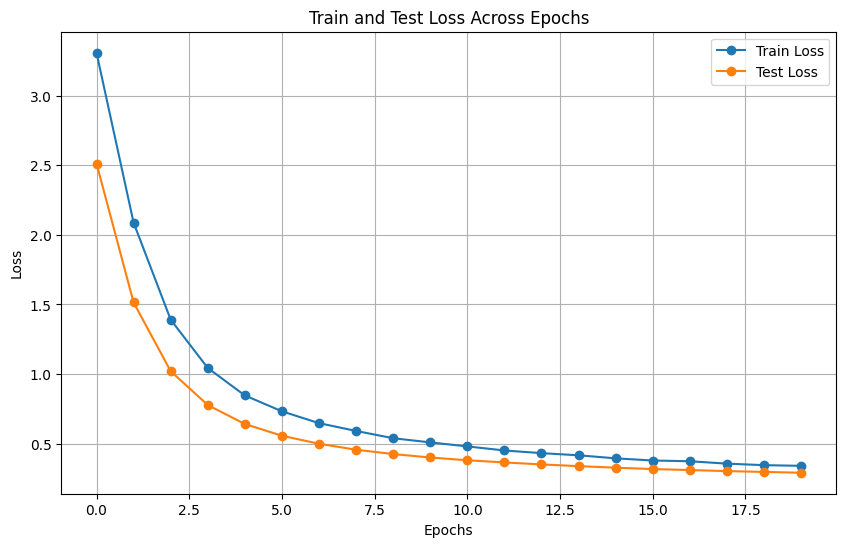

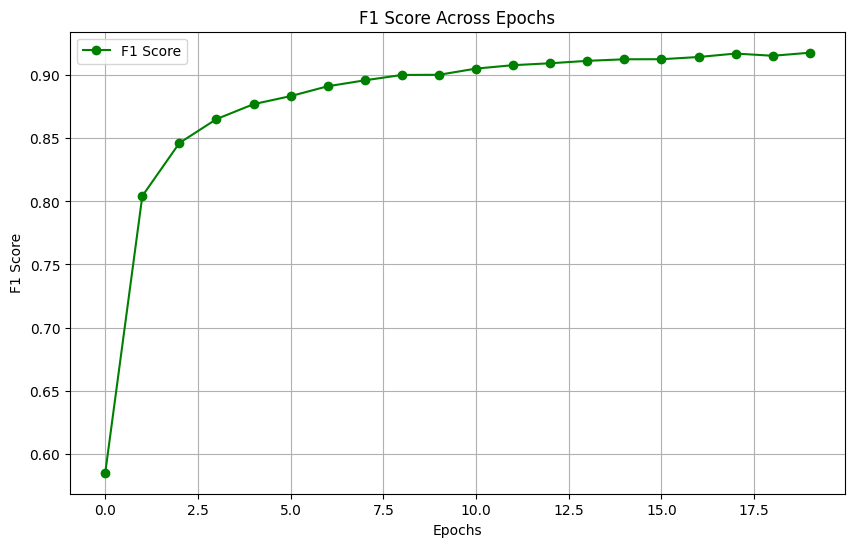

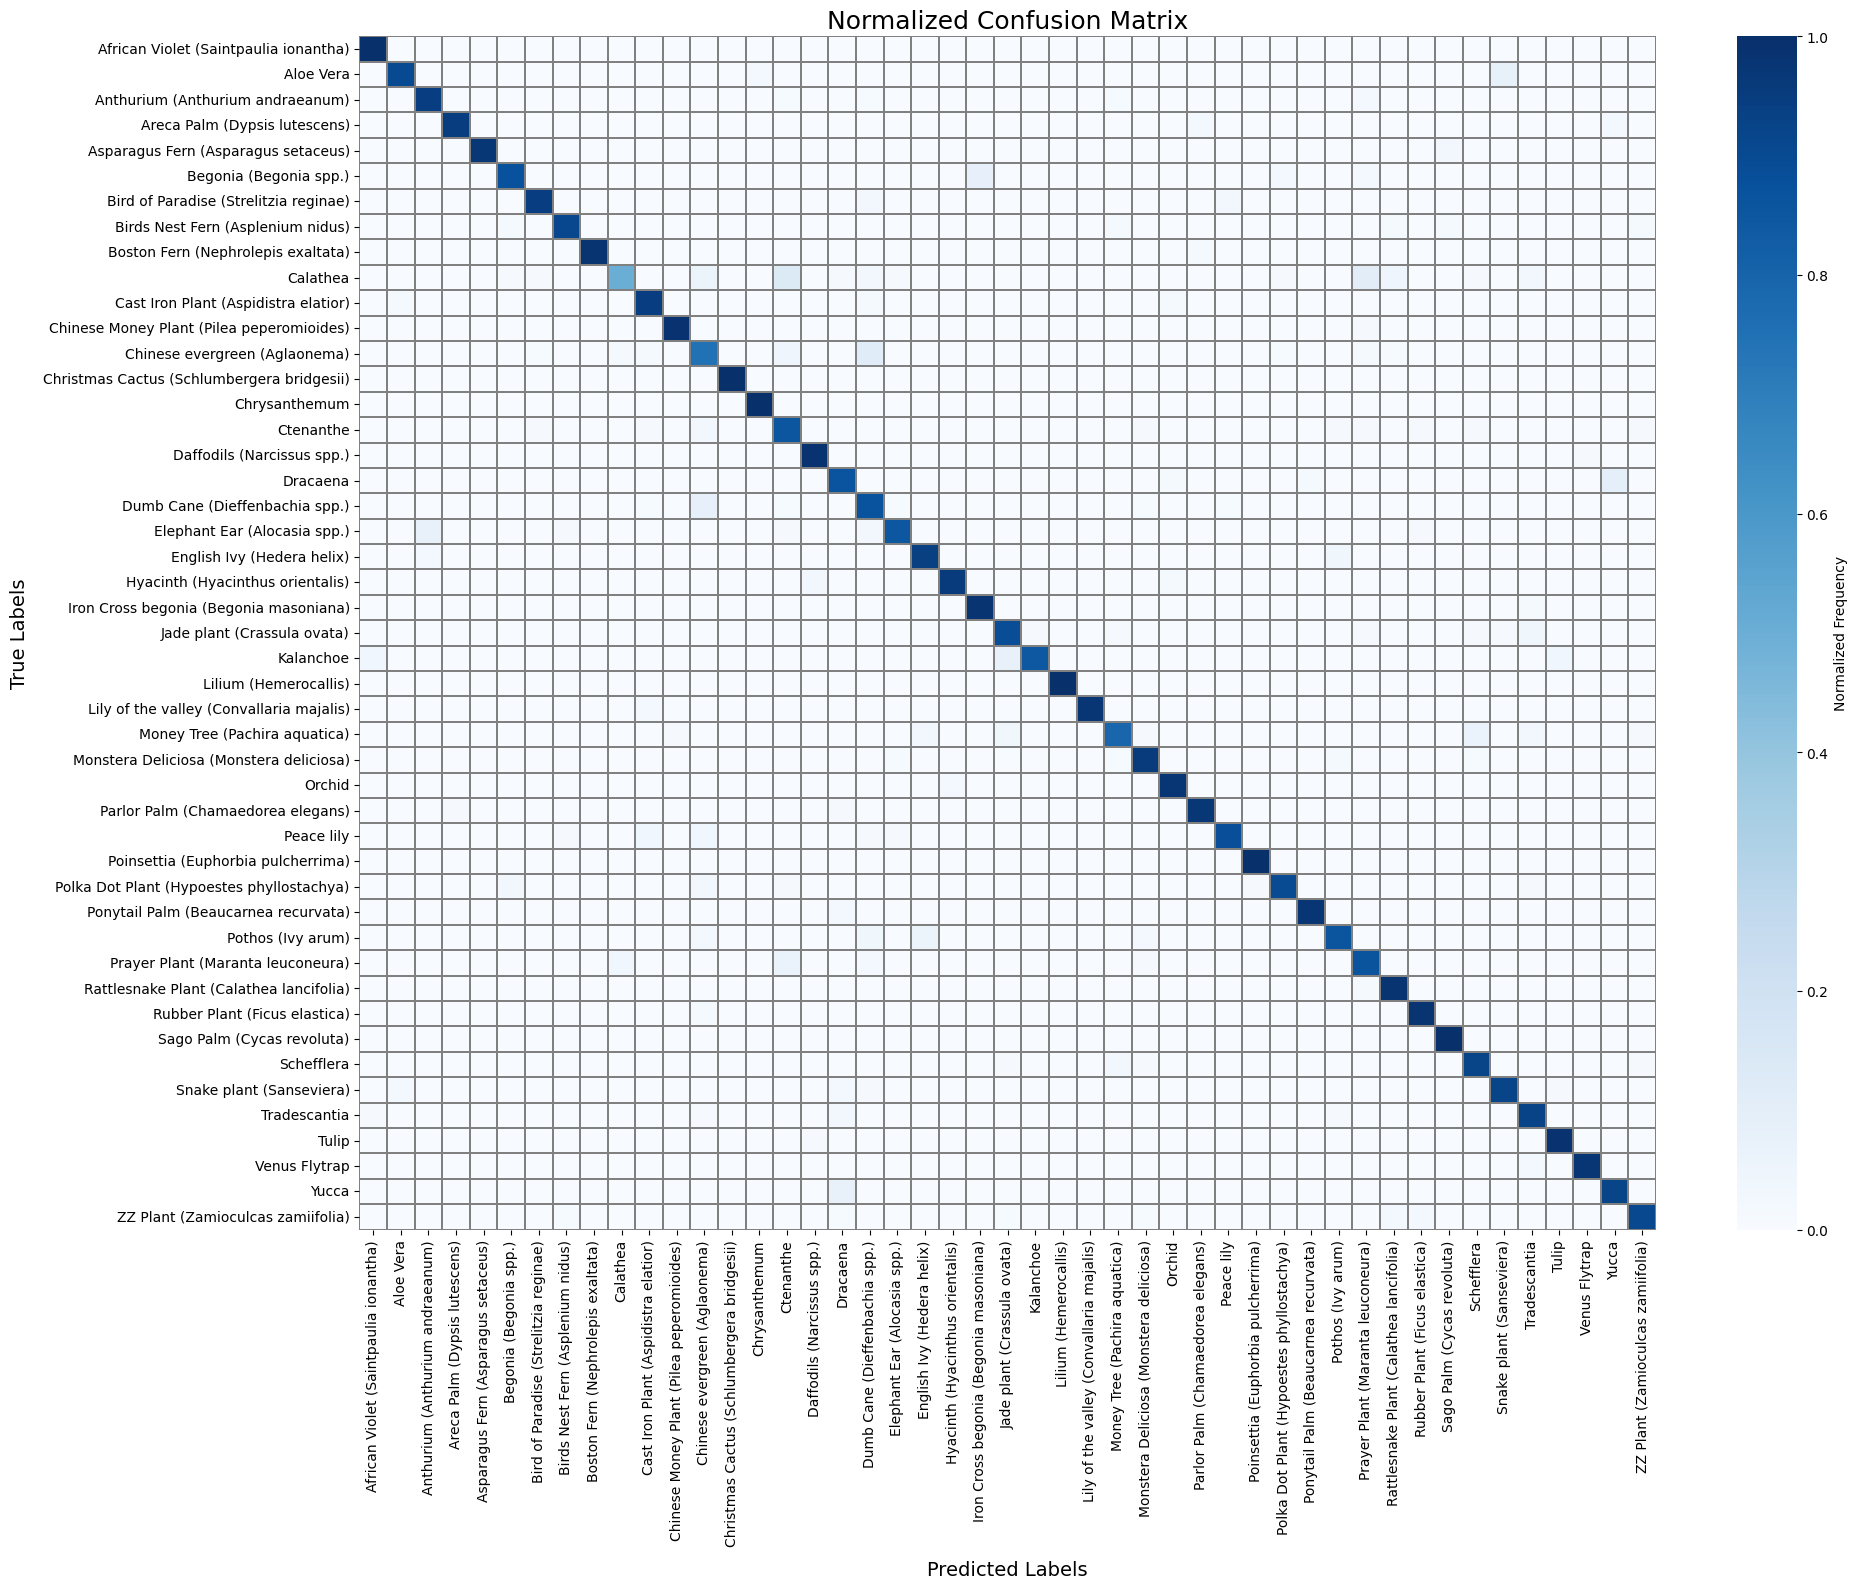

In [ ]:
# Visualizing train/test loss
plot_loss(train_losses, test_losses)

# Visualizing F1 scores
plot_f1_scores(f1_scores)

# Visualizing the confusion matrix for the last epoch
plot_confusion_matrix(conf_matrices[-1], class_names)


## Custom ViT

In [ ]:
from torch.optim.lr_scheduler import OneCycleLR

# Defining model and optimizer
model=model_vit3
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

# Defining scheduler
scheduler = OneCycleLR(optimizer, max_lr=0.001, steps_per_epoch=len(train_loader), epochs=25)

In [ ]:
# Initializing training
train_losses, test_losses, f1_scores, conf_matrices = train_test_loop(
    model=model_vit3,
    train_loader=train_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=25,
    patience=3,
    save_path="ViT3_best.pth"
)

print("Training complete!")

<ipython-input-12-ebfd03dc1cf0>:18: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/25 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/25 [Test]: 100%|██████████| 47/47 [01:49<00:00,  2.33s/it, loss=3.4, accuracy=0.112]


Epoch 1/25:
  Train Loss: 3.6212 | Train Accuracy: 0.0730
  Test Loss: 3.3955 | Test Accuracy: 0.1117
  F1 Score: 0.0738
  Learning Rate: 0.000040


Epoch 2/25 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 2/25 [Train]:   4%|▍         | 7/185 [00:19<08:22,  2.82s/it, loss=3.48, accuracy=0.0893]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 2/25 [Test]: 100%|██████████| 47/47 [01:51<00:00,  2.36s/it, loss=3.22, accuracy=0.148]


Epoch 2/25:
  Train Loss: 3.3952 | Train Accuracy: 0.1080
  Test Loss: 3.2156 | Test Accuracy: 0.1482
  F1 Score: 0.1271
  Learning Rate: 0.000040


Epoch 3/25 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 3/25 [Train]:   2%|▏         | 3/185 [00:08<08:52,  2.92s/it, loss=3.3, accuracy=0.146]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 3/25 [Test]: 100%|██████████| 47/47 [01:50<00:00,  2.36s/it, loss=3.03, accuracy=0.184]


Epoch 3/25:
  Train Loss: 3.2126 | Train Accuracy: 0.1469
  Test Loss: 3.0318 | Test Accuracy: 0.1844
  F1 Score: 0.1684
  Learning Rate: 0.000040


Epoch 4/25 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 4/25 [Test]: 100%|██████████| 47/47 [01:50<00:00,  2.34s/it, loss=2.85, accuracy=0.245]


Epoch 4/25:
  Train Loss: 3.0882 | Train Accuracy: 0.1745
  Test Loss: 2.8537 | Test Accuracy: 0.2450
  F1 Score: 0.2097
  Learning Rate: 0.000040


Epoch 5/25 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 5/25 [Train]:   1%|          | 1/185 [00:02<07:51,  2.56s/it, loss=2.9, accuracy=0.172]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 5/25 [Test]: 100%|██████████| 47/47 [01:50<00:00,  2.36s/it, loss=2.87, accuracy=0.215]


Epoch 5/25:
  Train Loss: 2.9341 | Train Accuracy: 0.2039
  Test Loss: 2.8713 | Test Accuracy: 0.2146
  F1 Score: 0.1904
  Learning Rate: 0.000040


Epoch 6/25 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 6/25 [Train]:   2%|▏         | 4/185 [00:09<07:05,  2.35s/it, loss=2.91, accuracy=0.219]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 6/25 [Test]: 100%|██████████| 47/47 [01:49<00:00,  2.32s/it, loss=2.63, accuracy=0.258]


Epoch 6/25:
  Train Loss: 2.8118 | Train Accuracy: 0.2326
  Test Loss: 2.6286 | Test Accuracy: 0.2575
  F1 Score: 0.2274
  Learning Rate: 0.000040


Epoch 7/25 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 7/25 [Train]:   2%|▏         | 3/185 [00:08<08:40,  2.86s/it, loss=2.79, accuracy=0.234]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 7/25 [Test]: 100%|██████████| 47/47 [01:49<00:00,  2.33s/it, loss=2.55, accuracy=0.291]


Epoch 7/25:
  Train Loss: 2.6676 | Train Accuracy: 0.2589
  Test Loss: 2.5533 | Test Accuracy: 0.2910
  F1 Score: 0.2755
  Learning Rate: 0.000040


Epoch 8/25 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 8/25 [Train]:   2%|▏         | 4/185 [00:09<07:20,  2.43s/it, loss=2.64, accuracy=0.27]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 8/25 [Test]: 100%|██████████| 47/47 [01:49<00:00,  2.34s/it, loss=2.43, accuracy=0.307]


Epoch 8/25:
  Train Loss: 2.5690 | Train Accuracy: 0.2847
  Test Loss: 2.4307 | Test Accuracy: 0.3069
  F1 Score: 0.2948
  Learning Rate: 0.000040


Epoch 9/25 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 9/25 [Train]:   1%|          | 2/185 [00:05<07:41,  2.52s/it, loss=2.3, accuracy=0.336]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 9/25 [Test]: 100%|██████████| 47/47 [01:49<00:00,  2.32s/it, loss=2.33, accuracy=0.337]


Epoch 9/25:
  Train Loss: 2.4409 | Train Accuracy: 0.3188
  Test Loss: 2.3254 | Test Accuracy: 0.3374
  F1 Score: 0.3214
  Learning Rate: 0.000040


Epoch 10/25 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 10/25 [Train]:   2%|▏         | 3/185 [00:08<09:11,  3.03s/it, loss=2.51, accuracy=0.307]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 10/25 [Test]: 100%|██████████| 47/47 [01:50<00:00,  2.35s/it, loss=2.24, accuracy=0.377]


Epoch 10/25:
  Train Loss: 2.3306 | Train Accuracy: 0.3361
  Test Loss: 2.2386 | Test Accuracy: 0.3773
  F1 Score: 0.3637
  Learning Rate: 0.000040


Epoch 11/25 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 11/25 [Train]:   4%|▍         | 7/185 [00:17<07:25,  2.50s/it, loss=2.23, accuracy=0.377]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 11/25 [Test]: 100%|██████████| 47/47 [01:49<00:00,  2.33s/it, loss=2.19, accuracy=0.365]


Epoch 11/25:
  Train Loss: 2.2769 | Train Accuracy: 0.3486
  Test Loss: 2.1890 | Test Accuracy: 0.3651
  F1 Score: 0.3501
  Learning Rate: 0.000040


Epoch 12/25 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 12/25 [Train]:   4%|▍         | 7/185 [00:18<07:36,  2.56s/it, loss=2.13, accuracy=0.393]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 12/25 [Test]: 100%|██████████| 47/47 [01:49<00:00,  2.33s/it, loss=2.17, accuracy=0.387]


Epoch 12/25:
  Train Loss: 2.1676 | Train Accuracy: 0.3783
  Test Loss: 2.1720 | Test Accuracy: 0.3871
  F1 Score: 0.3712
  Learning Rate: 0.000040


Epoch 13/25 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 13/25 [Train]:   1%|          | 1/185 [00:03<09:18,  3.04s/it, loss=1.96, accuracy=0.422]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 13/25 [Test]: 100%|██████████| 47/47 [01:50<00:00,  2.34s/it, loss=2.14, accuracy=0.394]


Epoch 13/25:
  Train Loss: 2.1280 | Train Accuracy: 0.3835
  Test Loss: 2.1443 | Test Accuracy: 0.3936
  F1 Score: 0.3763
  Learning Rate: 0.000040


Epoch 14/25 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 14/25 [Train]:   2%|▏         | 3/185 [00:07<07:48,  2.57s/it, loss=2.12, accuracy=0.432]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 14/25 [Test]: 100%|██████████| 47/47 [01:49<00:00,  2.33s/it, loss=2.09, accuracy=0.394]


Epoch 14/25:
  Train Loss: 2.0444 | Train Accuracy: 0.4101
  Test Loss: 2.0934 | Test Accuracy: 0.3939
  F1 Score: 0.3830
  Learning Rate: 0.000040


Epoch 15/25 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 15/25 [Test]: 100%|██████████| 47/47 [01:50<00:00,  2.34s/it, loss=2.02, accuracy=0.429]


Epoch 15/25:
  Train Loss: 1.9453 | Train Accuracy: 0.4315
  Test Loss: 2.0245 | Test Accuracy: 0.4294
  F1 Score: 0.4196
  Learning Rate: 0.000040


Epoch 16/25 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 16/25 [Train]:   1%|          | 1/185 [00:02<06:37,  2.16s/it, loss=2.16, accuracy=0.469]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 16/25 [Test]: 100%|██████████| 47/47 [01:49<00:00,  2.33s/it, loss=2.01, accuracy=0.414]


Epoch 16/25:
  Train Loss: 1.8836 | Train Accuracy: 0.4496
  Test Loss: 2.0090 | Test Accuracy: 0.4135
  F1 Score: 0.4049
  Learning Rate: 0.000040


Epoch 17/25 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 17/25 [Test]: 100%|██████████| 47/47 [01:49<00:00,  2.34s/it, loss=1.96, accuracy=0.435]


Epoch 17/25:
  Train Loss: 1.8307 | Train Accuracy: 0.4599
  Test Loss: 1.9567 | Test Accuracy: 0.4345
  F1 Score: 0.4313
  Learning Rate: 0.000040


Epoch 18/25 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 18/25 [Train]:   5%|▍         | 9/185 [00:22<07:27,  2.54s/it, loss=1.8, accuracy=0.444]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 18/25 [Test]: 100%|██████████| 47/47 [01:50<00:00,  2.35s/it, loss=1.93, accuracy=0.44]


Epoch 18/25:
  Train Loss: 1.7676 | Train Accuracy: 0.4783
  Test Loss: 1.9298 | Test Accuracy: 0.4396
  F1 Score: 0.4294
  Learning Rate: 0.000040


Epoch 19/25 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 19/25 [Train]:   6%|▌         | 11/185 [00:28<07:36,  2.62s/it, loss=1.64, accuracy=0.513]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 19/25 [Test]: 100%|██████████| 47/47 [01:49<00:00,  2.34s/it, loss=1.89, accuracy=0.458]


Epoch 19/25:
  Train Loss: 1.7143 | Train Accuracy: 0.4922
  Test Loss: 1.8935 | Test Accuracy: 0.4575
  F1 Score: 0.4549
  Learning Rate: 0.000040


Epoch 20/25 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 20/25 [Train]:   4%|▍         | 7/185 [00:17<07:16,  2.45s/it, loss=1.59, accuracy=0.518]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 20/25 [Test]: 100%|██████████| 47/47 [01:50<00:00,  2.36s/it, loss=1.86, accuracy=0.475]


Epoch 20/25:
  Train Loss: 1.6156 | Train Accuracy: 0.5143
  Test Loss: 1.8574 | Test Accuracy: 0.4751
  F1 Score: 0.4690
  Learning Rate: 0.000040


Epoch 21/25 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 21/25 [Train]:   1%|          | 1/185 [00:02<08:54,  2.90s/it, loss=1.58, accuracy=0.578]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 21/25 [Test]: 100%|██████████| 47/47 [01:49<00:00,  2.34s/it, loss=1.93, accuracy=0.453]


Epoch 21/25:
  Train Loss: 1.5934 | Train Accuracy: 0.5192
  Test Loss: 1.9307 | Test Accuracy: 0.4531
  F1 Score: 0.4408
  Learning Rate: 0.000041


Epoch 22/25 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 22/25 [Train]:   4%|▍         | 8/185 [00:19<07:06,  2.41s/it, loss=1.49, accuracy=0.545]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 22/25 [Test]: 100%|██████████| 47/47 [01:50<00:00,  2.35s/it, loss=1.84, accuracy=0.48]


Epoch 22/25:
  Train Loss: 1.5457 | Train Accuracy: 0.5302
  Test Loss: 1.8441 | Test Accuracy: 0.4802
  F1 Score: 0.4785
  Learning Rate: 0.000041


Epoch 23/25 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 23/25 [Train]:   1%|          | 2/185 [00:04<06:48,  2.23s/it, loss=1.38, accuracy=0.539]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 23/25 [Test]: 100%|██████████| 47/47 [01:49<00:00,  2.32s/it, loss=1.8, accuracy=0.491]


Epoch 23/25:
  Train Loss: 1.4710 | Train Accuracy: 0.5484
  Test Loss: 1.7960 | Test Accuracy: 0.4914
  F1 Score: 0.4891
  Learning Rate: 0.000041


Epoch 24/25 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 24/25 [Train]:   5%|▌         | 10/185 [00:25<07:37,  2.61s/it, loss=1.31, accuracy=0.583]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 24/25 [Test]: 100%|██████████| 47/47 [01:50<00:00,  2.35s/it, loss=1.83, accuracy=0.491]


Epoch 24/25:
  Train Loss: 1.4347 | Train Accuracy: 0.5579
  Test Loss: 1.8266 | Test Accuracy: 0.4907
  F1 Score: 0.4790
  Learning Rate: 0.000041


Epoch 25/25 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 25/25 [Train]:   1%|          | 1/185 [00:02<07:29,  2.44s/it, loss=1.45, accuracy=0.547]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 25/25 [Test]: 100%|██████████| 47/47 [01:51<00:00,  2.36s/it, loss=1.82, accuracy=0.496]


Epoch 25/25:
  Train Loss: 1.3518 | Train Accuracy: 0.5813
  Test Loss: 1.8218 | Test Accuracy: 0.4961
  F1 Score: 0.4928
  Learning Rate: 0.000041
Best model saved to ViT3_best.pth
Training complete!


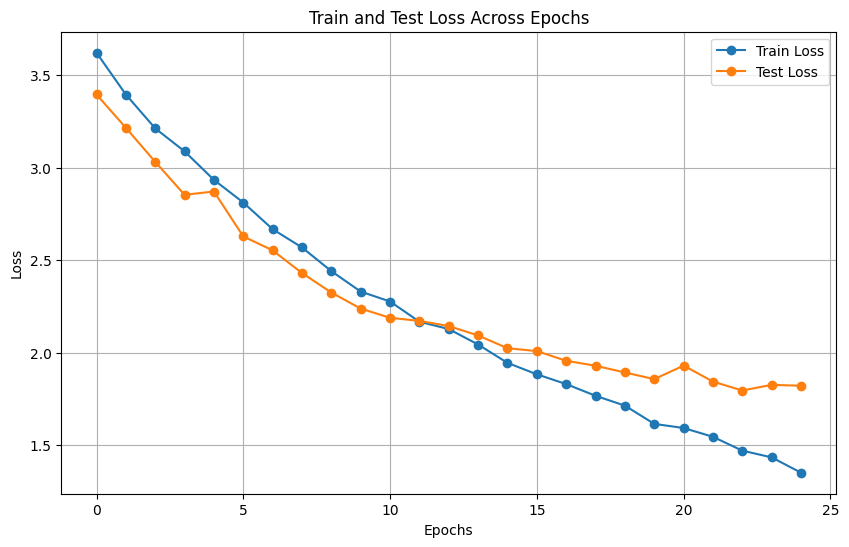

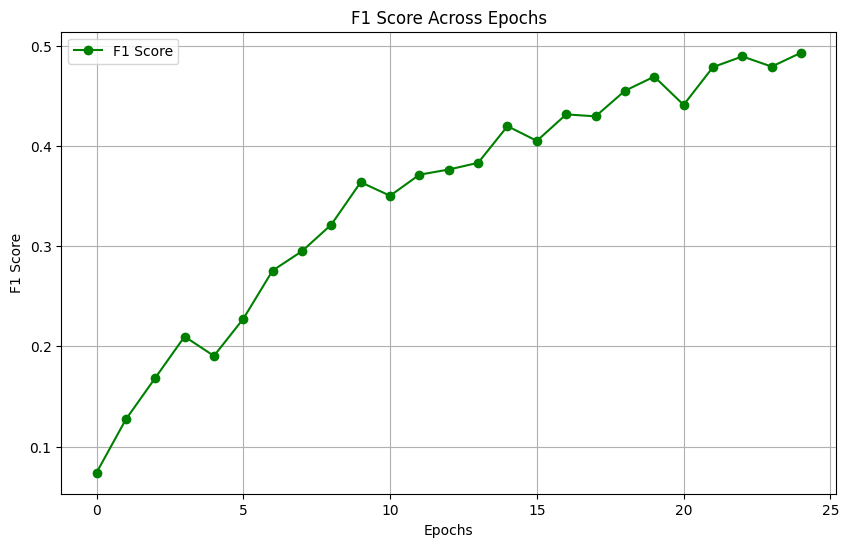

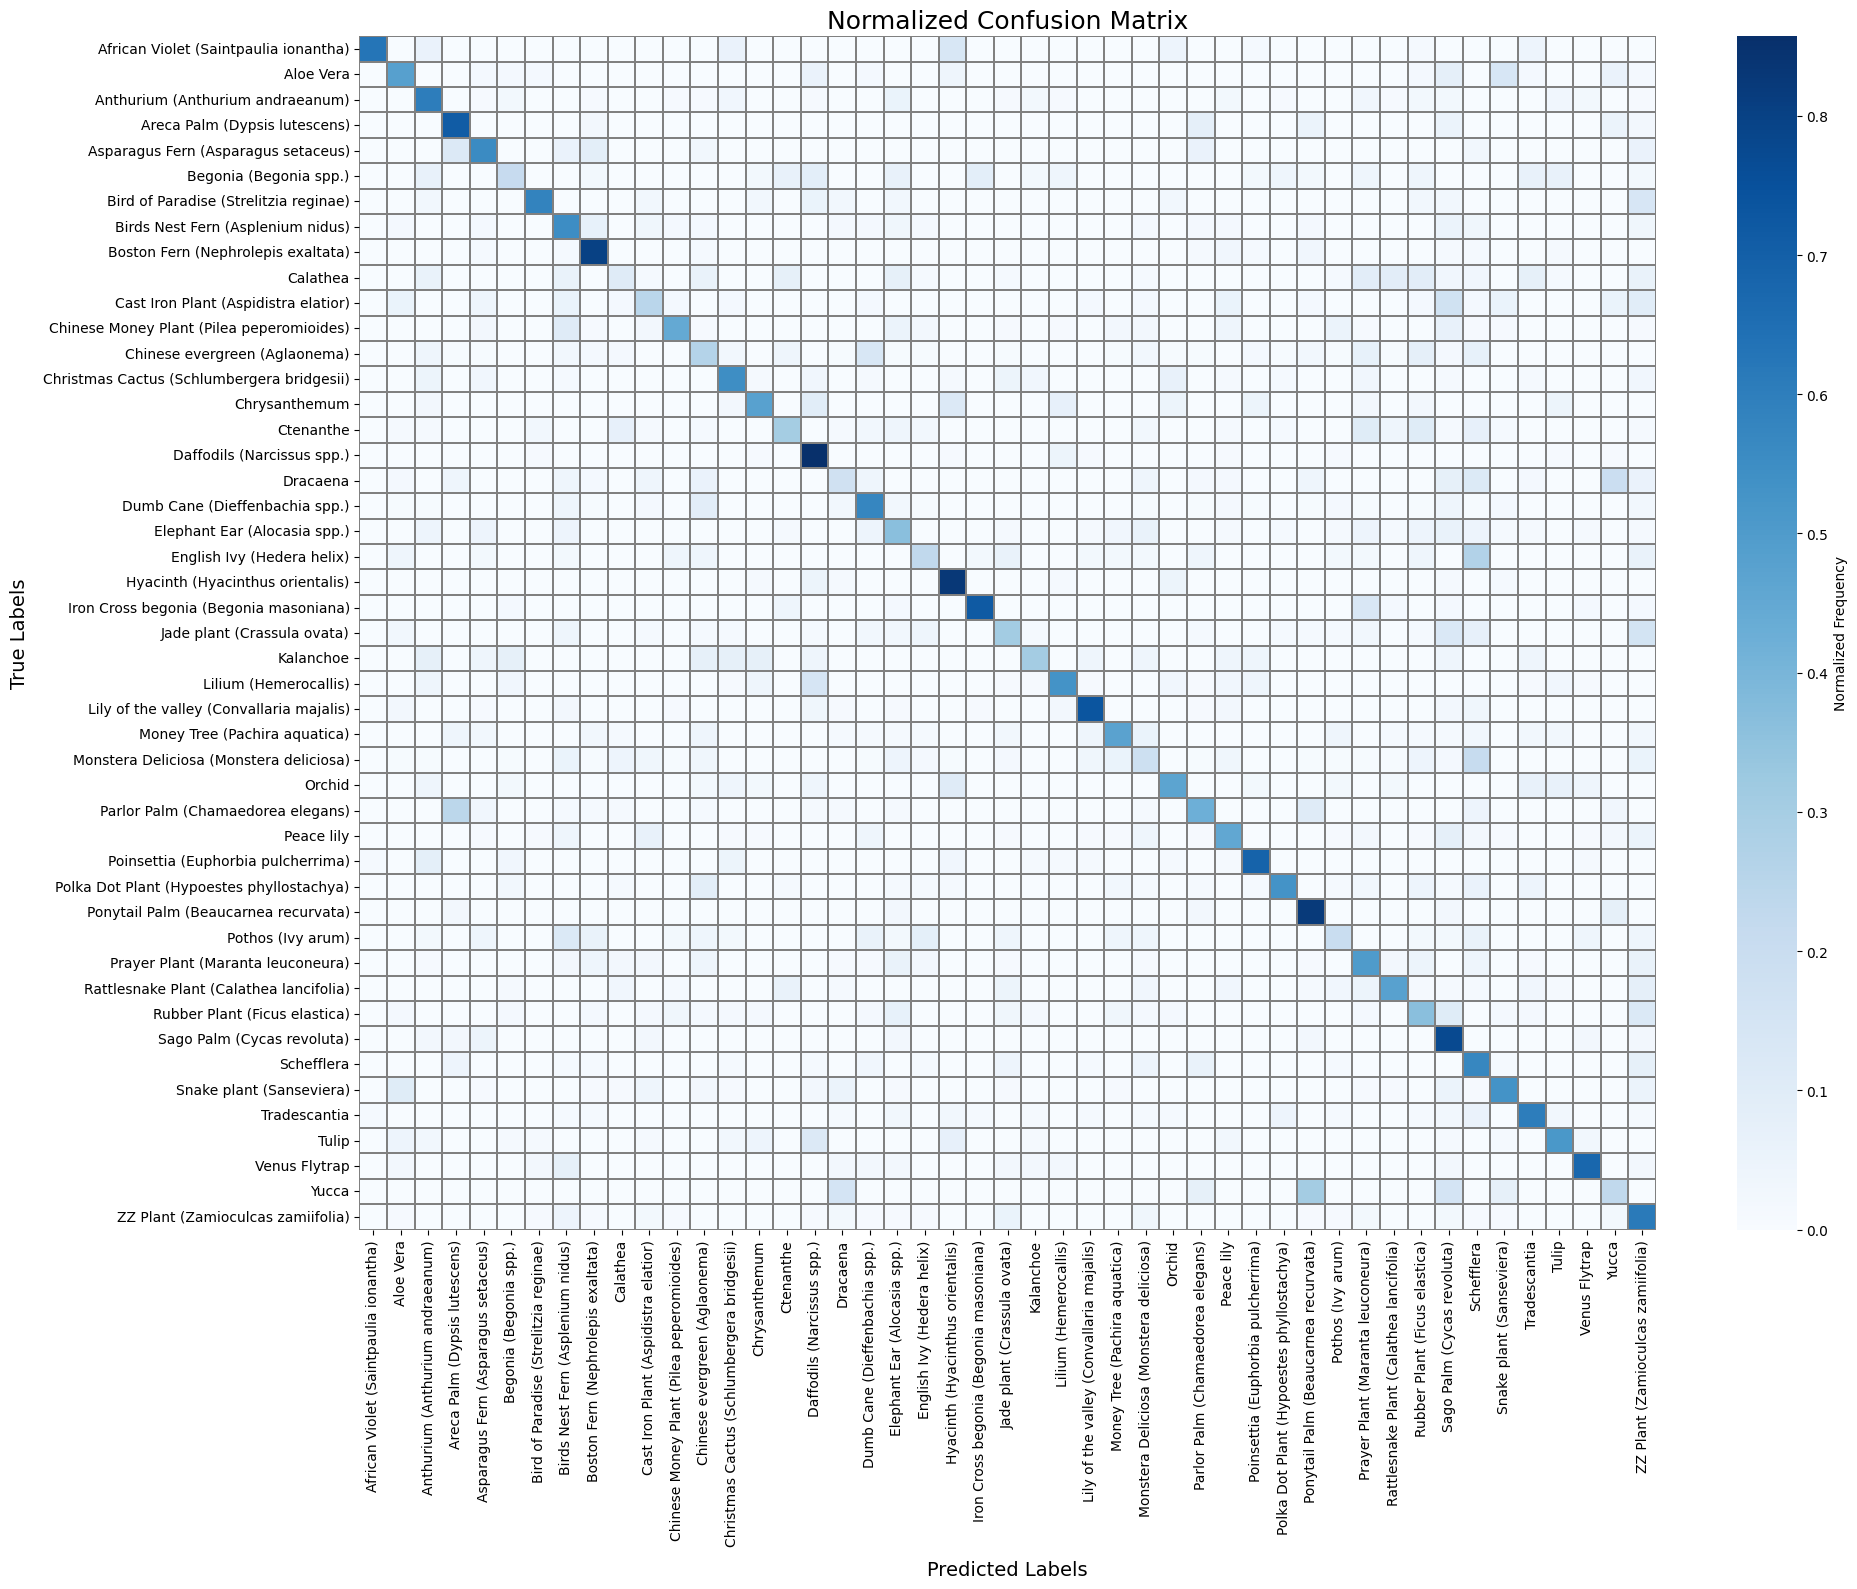

In [ ]:
# Visualizing train/test loss
plot_loss(train_losses, test_losses)

# Visualizing F1 scores
plot_f1_scores(f1_scores)

# Visualizing the confusion matrix for the last epoch
plot_confusion_matrix(conf_matrices[-1], class_names)

### Custom Effnet

In [ ]:
from torch.optim import SGD
from torch.optim.lr_scheduler import CyclicLR

# Defining the model and optimizer
model = model_effnet_b3
optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9)

# Defining the scheduler
scheduler = CyclicLR(
    optimizer,
    base_lr=0.0001,
    max_lr=0.001,
    step_size_up=len(train_loader) * 5,
    mode='triangular',
)

In [ ]:
#Initializing training
train_losses, test_losses, f1_scores, conf_matrices = train_test_loop(
    model=model_effnet_b3,
    train_loader=train_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=30,
    patience=3,
    save_path="Effnet_best.pth"
)

print("Training complete!")

<ipython-input-12-ebfd03dc1cf0>:18: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/30 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/30 [Test]: 100%|██████████| 47/47 [01:44<00:00,  2.23s/it, loss=4.1, accuracy=0.0193]


Epoch 1/30:
  Train Loss: 3.8426 | Train Accuracy: 0.0275
  Test Loss: 4.0985 | Test Accuracy: 0.0193
  F1 Score: 0.0078
  Learning Rate: 0.000040


Epoch 2/30 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 2/30 [Train]:   5%|▍         | 9/185 [00:24<08:11,  2.79s/it, loss=3.85, accuracy=0.0174]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 2/30 [Test]: 100%|██████████| 47/47 [01:44<00:00,  2.22s/it, loss=3.96, accuracy=0.0369]


Epoch 2/30:
  Train Loss: 3.8195 | Train Accuracy: 0.0283
  Test Loss: 3.9565 | Test Accuracy: 0.0369
  F1 Score: 0.0129
  Learning Rate: 0.000040


Epoch 3/30 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 3/30 [Train]:   1%|          | 1/185 [00:03<10:26,  3.40s/it, loss=3.83, accuracy=0.0469]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 3/30 [Test]: 100%|██████████| 47/47 [01:43<00:00,  2.20s/it, loss=4.08, accuracy=0.0457]


Epoch 3/30:
  Train Loss: 3.8032 | Train Accuracy: 0.0346
  Test Loss: 4.0827 | Test Accuracy: 0.0457
  F1 Score: 0.0184
  Learning Rate: 0.000040


Epoch 4/30 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 4/30 [Train]:   3%|▎         | 5/185 [00:13<07:52,  2.63s/it, loss=3.78, accuracy=0.0281]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 4/30 [Test]: 100%|██████████| 47/47 [01:43<00:00,  2.19s/it, loss=3.77, accuracy=0.0589]


Epoch 4/30:
  Train Loss: 3.7439 | Train Accuracy: 0.0482
  Test Loss: 3.7673 | Test Accuracy: 0.0589
  F1 Score: 0.0344
  Learning Rate: 0.000040


Epoch 5/30 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 5/30 [Train]:   3%|▎         | 5/185 [00:12<07:43,  2.58s/it, loss=3.63, accuracy=0.0656]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 5/30 [Test]: 100%|██████████| 47/47 [01:43<00:00,  2.20s/it, loss=3.57, accuracy=0.0876]


Epoch 5/30:
  Train Loss: 3.6195 | Train Accuracy: 0.0685
  Test Loss: 3.5733 | Test Accuracy: 0.0876
  F1 Score: 0.0501
  Learning Rate: 0.000040


Epoch 6/30 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 6/30 [Train]:   5%|▍         | 9/185 [00:21<07:28,  2.55s/it, loss=3.55, accuracy=0.0799]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 6/30 [Test]: 100%|██████████| 47/47 [01:43<00:00,  2.20s/it, loss=3.52, accuracy=0.111]


Epoch 6/30:
  Train Loss: 3.5016 | Train Accuracy: 0.0870
  Test Loss: 3.5244 | Test Accuracy: 0.1110
  F1 Score: 0.0777
  Learning Rate: 0.000040


Epoch 7/30 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 7/30 [Train]:   1%|          | 1/185 [00:03<09:19,  3.04s/it, loss=3.49, accuracy=0.109]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 7/30 [Test]: 100%|██████████| 47/47 [01:42<00:00,  2.19s/it, loss=3.45, accuracy=0.12]


Epoch 7/30:
  Train Loss: 3.4198 | Train Accuracy: 0.1036
  Test Loss: 3.4456 | Test Accuracy: 0.1201
  F1 Score: 0.0913
  Learning Rate: 0.000040


Epoch 8/30 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 8/30 [Train]:   5%|▍         | 9/185 [00:22<07:18,  2.49s/it, loss=3.39, accuracy=0.113]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 8/30 [Test]: 100%|██████████| 47/47 [01:43<00:00,  2.20s/it, loss=3.31, accuracy=0.146]


Epoch 8/30:
  Train Loss: 3.3567 | Train Accuracy: 0.1053
  Test Loss: 3.3065 | Test Accuracy: 0.1459
  F1 Score: 0.1146
  Learning Rate: 0.000040


Epoch 9/30 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 9/30 [Train]:   9%|▊         | 16/185 [00:42<07:30,  2.66s/it, loss=3.33, accuracy=0.116]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 9/30 [Test]: 100%|██████████| 47/47 [01:43<00:00,  2.20s/it, loss=3.21, accuracy=0.155]


Epoch 9/30:
  Train Loss: 3.3047 | Train Accuracy: 0.1201
  Test Loss: 3.2085 | Test Accuracy: 0.1547
  F1 Score: 0.1170
  Learning Rate: 0.000040


Epoch 10/30 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 10/30 [Train]:   3%|▎         | 6/185 [00:15<07:41,  2.58s/it, loss=3.3, accuracy=0.138]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 10/30 [Test]: 100%|██████████| 47/47 [01:44<00:00,  2.22s/it, loss=3.16, accuracy=0.161]


Epoch 10/30:
  Train Loss: 3.2595 | Train Accuracy: 0.1333
  Test Loss: 3.1645 | Test Accuracy: 0.1614
  F1 Score: 0.1299
  Learning Rate: 0.000040


Epoch 11/30 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 11/30 [Train]:   1%|          | 1/185 [00:02<07:49,  2.55s/it, loss=3.31, accuracy=0.188]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 11/30 [Test]: 100%|██████████| 47/47 [01:45<00:00,  2.25s/it, loss=3.03, accuracy=0.177]


Epoch 11/30:
  Train Loss: 3.1799 | Train Accuracy: 0.1410
  Test Loss: 3.0292 | Test Accuracy: 0.1766
  F1 Score: 0.1426
  Learning Rate: 0.000040


Epoch 12/30 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 12/30 [Train]:   3%|▎         | 5/185 [00:12<08:00,  2.67s/it, loss=3.19, accuracy=0.116]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 12/30 [Test]: 100%|██████████| 47/47 [01:44<00:00,  2.23s/it, loss=3.05, accuracy=0.189]


Epoch 12/30:
  Train Loss: 3.1329 | Train Accuracy: 0.1513
  Test Loss: 3.0458 | Test Accuracy: 0.1888
  F1 Score: 0.1535
  Learning Rate: 0.000040


Epoch 13/30 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 13/30 [Test]: 100%|██████████| 47/47 [01:44<00:00,  2.22s/it, loss=2.95, accuracy=0.198]


Epoch 13/30:
  Train Loss: 3.0852 | Train Accuracy: 0.1627
  Test Loss: 2.9483 | Test Accuracy: 0.1976
  F1 Score: 0.1636
  Learning Rate: 0.000040


Epoch 14/30 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 14/30 [Train]:   8%|▊         | 15/185 [00:41<07:31,  2.66s/it, loss=3.11, accuracy=0.171]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 14/30 [Test]: 100%|██████████| 47/47 [01:44<00:00,  2.22s/it, loss=2.91, accuracy=0.204]


Epoch 14/30:
  Train Loss: 3.0379 | Train Accuracy: 0.1707
  Test Loss: 2.9084 | Test Accuracy: 0.2037
  F1 Score: 0.1778
  Learning Rate: 0.000040


Epoch 15/30 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 15/30 [Train]:   7%|▋         | 13/185 [00:33<07:11,  2.51s/it, loss=3.02, accuracy=0.169]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 15/30 [Test]: 100%|██████████| 47/47 [01:44<00:00,  2.22s/it, loss=2.84, accuracy=0.223]


Epoch 15/30:
  Train Loss: 2.9941 | Train Accuracy: 0.1816
  Test Loss: 2.8444 | Test Accuracy: 0.2227
  F1 Score: 0.1988
  Learning Rate: 0.000040


Epoch 16/30 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 16/30 [Train]:   2%|▏         | 4/185 [00:09<06:46,  2.24s/it, loss=2.87, accuracy=0.242]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 16/30 [Test]: 100%|██████████| 47/47 [01:44<00:00,  2.23s/it, loss=2.8, accuracy=0.23]


Epoch 16/30:
  Train Loss: 2.9504 | Train Accuracy: 0.1916
  Test Loss: 2.7982 | Test Accuracy: 0.2301
  F1 Score: 0.2094
  Learning Rate: 0.000040


Epoch 17/30 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 17/30 [Train]:   1%|          | 1/185 [00:02<07:52,  2.57s/it, loss=2.93, accuracy=0.156]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 17/30 [Test]: 100%|██████████| 47/47 [01:45<00:00,  2.24s/it, loss=2.78, accuracy=0.229]


Epoch 17/30:
  Train Loss: 2.9110 | Train Accuracy: 0.1963
  Test Loss: 2.7781 | Test Accuracy: 0.2291
  F1 Score: 0.2055
  Learning Rate: 0.000040


Epoch 18/30 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 18/30 [Train]:   5%|▌         | 10/185 [00:25<07:28,  2.56s/it, loss=2.9, accuracy=0.206]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 18/30 [Test]: 100%|██████████| 47/47 [01:45<00:00,  2.24s/it, loss=2.74, accuracy=0.249]


Epoch 18/30:
  Train Loss: 2.8695 | Train Accuracy: 0.2091
  Test Loss: 2.7433 | Test Accuracy: 0.2491
  F1 Score: 0.2211
  Learning Rate: 0.000040


Epoch 19/30 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 19/30 [Train]:   2%|▏         | 3/185 [00:07<07:32,  2.48s/it, loss=2.87, accuracy=0.203]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 19/30 [Test]: 100%|██████████| 47/47 [01:45<00:00,  2.25s/it, loss=2.72, accuracy=0.257]


Epoch 19/30:
  Train Loss: 2.8359 | Train Accuracy: 0.2154
  Test Loss: 2.7180 | Test Accuracy: 0.2569
  F1 Score: 0.2335
  Learning Rate: 0.000040


Epoch 20/30 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 20/30 [Train]:   6%|▌         | 11/185 [00:30<08:41,  3.00s/it, loss=2.8, accuracy=0.229]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 20/30 [Test]: 100%|██████████| 47/47 [01:44<00:00,  2.23s/it, loss=2.7, accuracy=0.261]


Epoch 20/30:
  Train Loss: 2.7897 | Train Accuracy: 0.2230
  Test Loss: 2.7000 | Test Accuracy: 0.2606
  F1 Score: 0.2393
  Learning Rate: 0.000040


Epoch 21/30 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 21/30 [Test]: 100%|██████████| 47/47 [01:42<00:00,  2.19s/it, loss=2.63, accuracy=0.267]


Epoch 21/30:
  Train Loss: 2.7723 | Train Accuracy: 0.2303
  Test Loss: 2.6333 | Test Accuracy: 0.2673
  F1 Score: 0.2396
  Learning Rate: 0.000041


Epoch 22/30 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 22/30 [Train]:   2%|▏         | 4/185 [00:09<07:17,  2.42s/it, loss=2.6, accuracy=0.273]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 22/30 [Test]: 100%|██████████| 47/47 [01:43<00:00,  2.21s/it, loss=2.62, accuracy=0.277]


Epoch 22/30:
  Train Loss: 2.7249 | Train Accuracy: 0.2402
  Test Loss: 2.6235 | Test Accuracy: 0.2772
  F1 Score: 0.2549
  Learning Rate: 0.000041


Epoch 23/30 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 23/30 [Train]:   2%|▏         | 3/185 [00:06<06:49,  2.25s/it, loss=2.65, accuracy=0.271]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 23/30 [Test]: 100%|██████████| 47/47 [01:45<00:00,  2.24s/it, loss=2.63, accuracy=0.276]


Epoch 23/30:
  Train Loss: 2.6909 | Train Accuracy: 0.2498
  Test Loss: 2.6306 | Test Accuracy: 0.2765
  F1 Score: 0.2545
  Learning Rate: 0.000041


Epoch 24/30 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 24/30 [Train]:   8%|▊         | 14/185 [00:36<06:57,  2.44s/it, loss=2.63, accuracy=0.273]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 24/30 [Test]: 100%|██████████| 47/47 [01:44<00:00,  2.23s/it, loss=2.62, accuracy=0.282]


Epoch 24/30:
  Train Loss: 2.6570 | Train Accuracy: 0.2573
  Test Loss: 2.6163 | Test Accuracy: 0.2819
  F1 Score: 0.2590
  Learning Rate: 0.000041


Epoch 25/30 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 25/30 [Train]:   1%|          | 1/185 [00:02<08:50,  2.88s/it, loss=2.63, accuracy=0.25]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 25/30 [Test]: 100%|██████████| 47/47 [01:45<00:00,  2.24s/it, loss=2.53, accuracy=0.302]


Epoch 25/30:
  Train Loss: 2.6052 | Train Accuracy: 0.2687
  Test Loss: 2.5298 | Test Accuracy: 0.3022
  F1 Score: 0.2802
  Learning Rate: 0.000041


Epoch 26/30 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 26/30 [Train]:   4%|▍         | 8/185 [00:19<07:04,  2.40s/it, loss=2.52, accuracy=0.33]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 26/30 [Test]: 100%|██████████| 47/47 [01:45<00:00,  2.24s/it, loss=2.49, accuracy=0.315]


Epoch 26/30:
  Train Loss: 2.5684 | Train Accuracy: 0.2777
  Test Loss: 2.4948 | Test Accuracy: 0.3147
  F1 Score: 0.2942
  Learning Rate: 0.000041


Epoch 27/30 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 27/30 [Test]: 100%|██████████| 47/47 [01:45<00:00,  2.24s/it, loss=2.45, accuracy=0.321]


Epoch 27/30:
  Train Loss: 2.5331 | Train Accuracy: 0.2848
  Test Loss: 2.4511 | Test Accuracy: 0.3212
  F1 Score: 0.2968
  Learning Rate: 0.000041


Epoch 28/30 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 28/30 [Train]:   3%|▎         | 6/185 [00:15<07:27,  2.50s/it, loss=2.56, accuracy=0.284]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 28/30 [Test]: 100%|██████████| 47/47 [01:45<00:00,  2.25s/it, loss=2.43, accuracy=0.325]


Epoch 28/30:
  Train Loss: 2.5077 | Train Accuracy: 0.2844
  Test Loss: 2.4327 | Test Accuracy: 0.3249
  F1 Score: 0.3039
  Learning Rate: 0.000041


Epoch 29/30 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 29/30 [Train]:   5%|▍         | 9/185 [00:22<07:31,  2.56s/it, loss=2.39, accuracy=0.312]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 29/30 [Test]: 100%|██████████| 47/47 [01:45<00:00,  2.25s/it, loss=2.38, accuracy=0.334]


Epoch 29/30:
  Train Loss: 2.4564 | Train Accuracy: 0.3039
  Test Loss: 2.3815 | Test Accuracy: 0.3343
  F1 Score: 0.3147
  Learning Rate: 0.000041


Epoch 30/30 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
<ipython-input-12-ebfd03dc1cf0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 30/30 [Test]: 100%|██████████| 47/47 [01:45<00:00,  2.25s/it, loss=2.33, accuracy=0.342]

Epoch 30/30:
  Train Loss: 2.4059 | Train Accuracy: 0.3111
  Test Loss: 2.3290 | Test Accuracy: 0.3421
  F1 Score: 0.3243
  Learning Rate: 0.000041
Best model saved to Effnet_best.pth
Training complete!


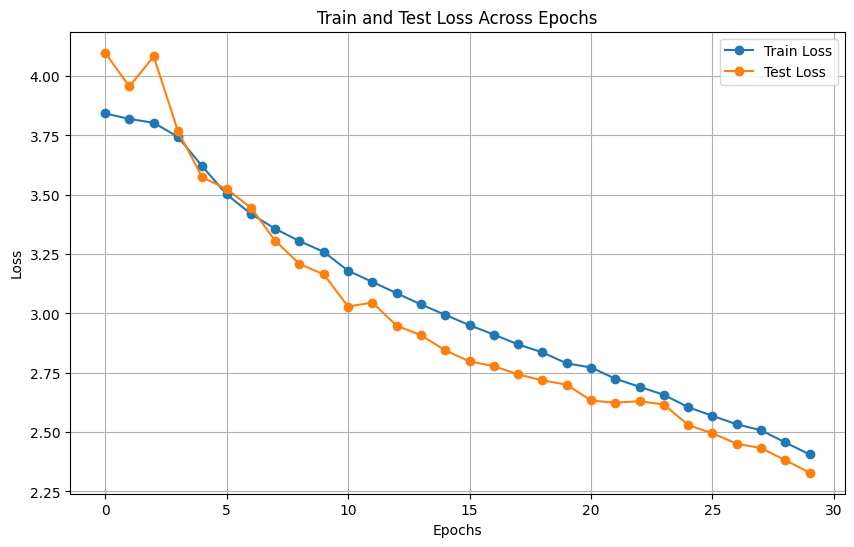

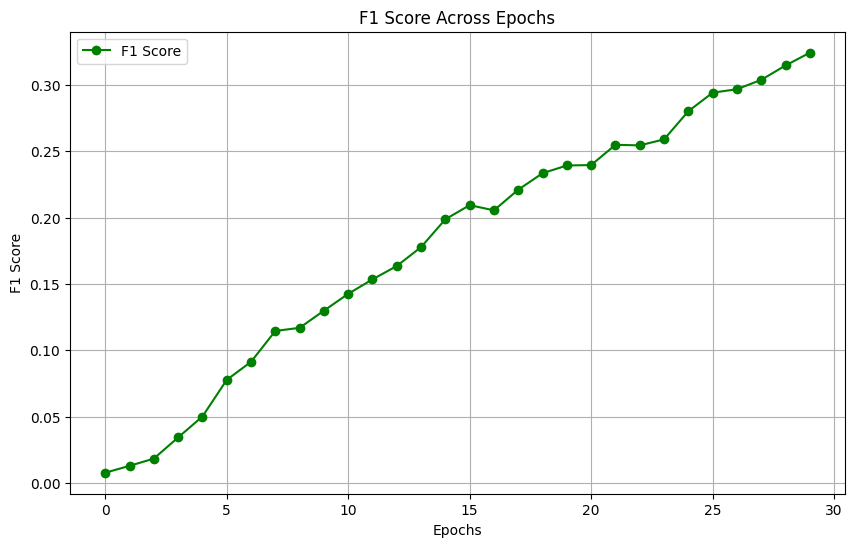

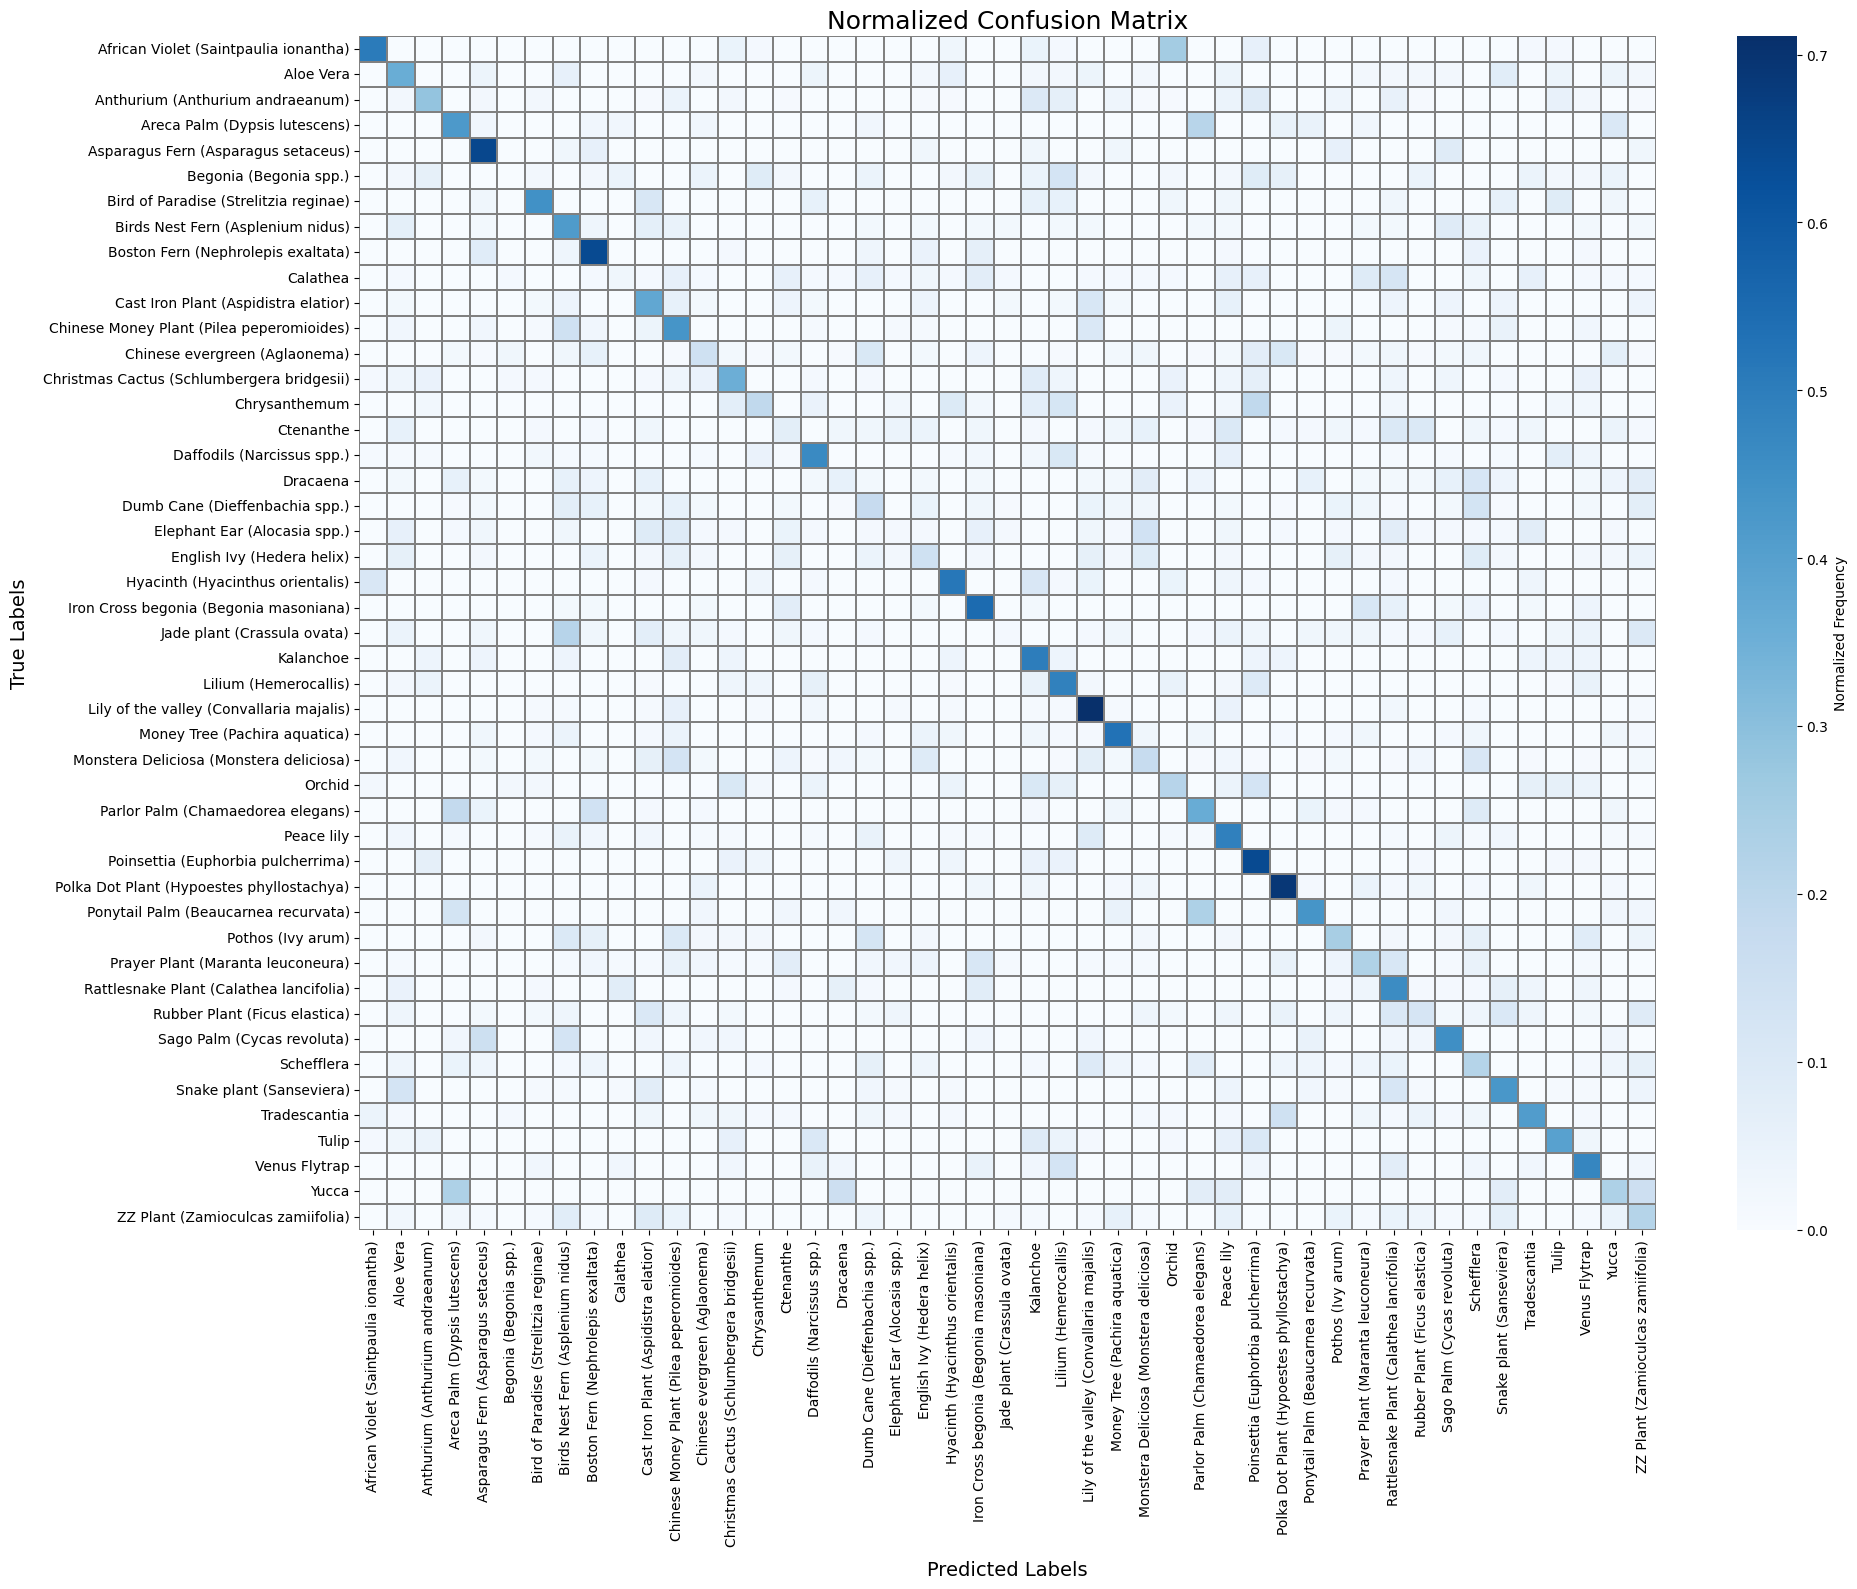

In [ ]:
# Visualizing train/test loss
plot_loss(train_losses, test_losses)

# Visualizing F1 scores
plot_f1_scores(f1_scores)

# Visualizing the confusion matrix for the last epoch
plot_confusion_matrix(conf_matrices[-1], class_names)

In [17]:
from google.colab import files
import pandas as pd

# Uploading the pet safety CSV
uploaded = files.upload()

# Loading the CSV into a DataFrame
safety_df = pd.read_csv(next(iter(uploaded)))
print("Safety CSV file loaded successfully!")
print(safety_df.head())

# Create a dictionary for disease-remedy mapping
plant_to_toxicity = dict(zip(safety_df['Plant'], safety_df['Toxicity']))

Saving updated_full_plant_toxicity.csv to updated_full_plant_toxicity (1).csv
Safety CSV file loaded successfully!
                                   Plant  \
0  African Violet (Saintpaulia ionantha)   
1                              Aloe Vera   
2       Anthurium (Anthurium andraeanum)   
3          Areca Palm (Dypsis lutescens)   
4    Asparagus Fern (Asparagus setaceus)   

                                            Toxicity  
0  For Cats: Non-Toxic, For Dogs: Non-Toxic, For ...  
1  For Cats: Toxic: Causes vomiting and diarrhea,...  
2  For Cats: Toxic: Causes oral irritation, For D...  
3  For Cats: Non-Toxic, For Dogs: Non-Toxic, For ...  
4  For Cats: Toxic: Causes skin irritation and di...  


<ipython-input-21-d8bc5eea082c>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


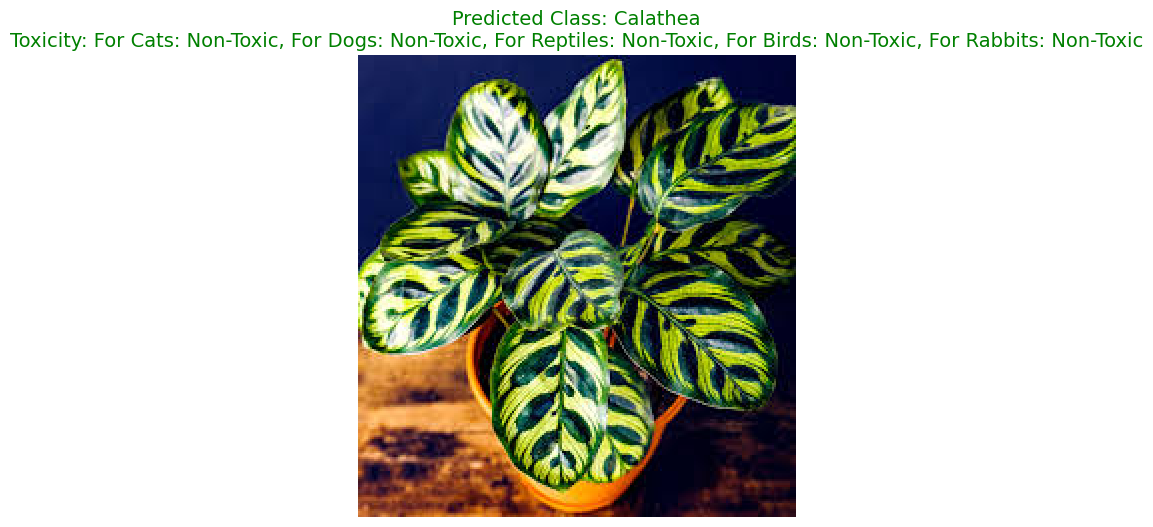

In [21]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Defining the transformation for the input image
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize image to match ViT input size
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Function to load the saved model
def load_model(model_path, model, device):
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    model.to(device)
    return model

# Function to make a prediction
def predict_image(image_path, model, class_names, device):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    input_tensor = image_transform(image).unsqueeze(0).to(device)

    # Perform inference
    with torch.no_grad():
        outputs = model(input_tensor)
        _, predicted = outputs.max(1)

    predicted_class = class_names[predicted.item()]
    return predicted_class

# Loading the trained ViT model
model_vit2 = load_model("ViT2_best.pth", model_vit, device)

# Function to get the toxicity of the predicted class
def get_toxicity(predicted_class, plant_to_toxicity):
    return plant_to_toxicity.get(predicted_class, "Toxicity info not available")

# Path to the input image
image_path = "/content/Calathea.jpg"

# Getting the prediction
predicted_class = predict_image(image_path, model_vit2, class_names, device)

# Getting the toxicity info for the predicted class
predicted_toxicity = get_toxicity(predicted_class, plant_to_toxicity)

# Function to display the image and prediction
def show_image_with_prediction(image_path, predicted_class, predicted_toxicity):
    image = Image.open(image_path).convert("RGB")

    # Display the image
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Predicted Class: {predicted_class}\nToxicity: {predicted_toxicity}", fontsize=14, color="green")
    plt.show()

# Displaying the image and prediction
show_image_with_prediction(image_path, predicted_class, predicted_toxicity)


<ipython-input-22-367acfbec0e5>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


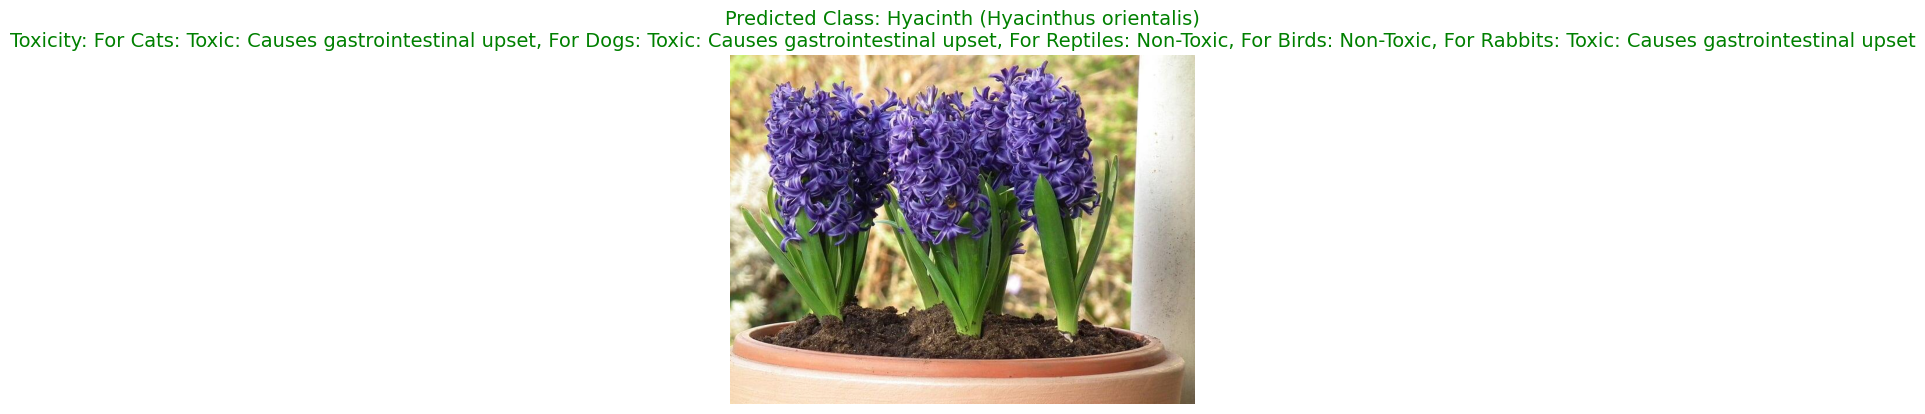

In [22]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Defining the transformation for the input image
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize image to match ViT input size
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Function to load the saved model
def load_model(model_path, model, device):
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    model.to(device)
    return model

# Function to make a prediction
def predict_image(image_path, model, class_names, device):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    input_tensor = image_transform(image).unsqueeze(0).to(device)

    # Perform inference
    with torch.no_grad():
        outputs = model(input_tensor)
        _, predicted = outputs.max(1)

    predicted_class = class_names[predicted.item()]
    return predicted_class

# Loading the trained ViT model
model_vit2 = load_model("ViT2_best.pth", model_vit, device)

# Function to get the toxicity of the predicted class
def get_toxicity(predicted_class, plant_to_toxicity):
    return plant_to_toxicity.get(predicted_class, "Toxicity info not available")

# Path to the input image
image_path = "/content/Hyacinth.jpg"

# Getting the prediction
predicted_class = predict_image(image_path, model_vit2, class_names, device)

# Getting the toxicity info for the predicted class
predicted_toxicity = get_toxicity(predicted_class, plant_to_toxicity)

# Function to display the image and prediction
def show_image_with_prediction(image_path, predicted_class, predicted_toxicity):
    image = Image.open(image_path).convert("RGB")

    # Display the image
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Predicted Class: {predicted_class}\nToxicity: {predicted_toxicity}", fontsize=14, color="green")
    plt.show()

# Displaying the image and prediction
show_image_with_prediction(image_path, predicted_class, predicted_toxicity)

----